In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller

#display options
import warnings
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
warnings.filterwarnings('ignore')
sns.set(rc={'image.cmap': 'coolwarm'})
pd.set_option('display.max_columns', 500)
%config InlineBackend.figure_format = "retina"
plt.style.use("fivethirtyeight")

In [2]:
df = pd.read_csv('au_data.csv')

# Data Cleaning

In [3]:
df['Date'] = pd.to_datetime(df['Date'])
dollar_cols = ['Net Total Revenue','Net Product Revenue','Net Shipping Revenue','Cost of Goods Sold','Shipping Cost']
df[dollar_cols] = df[dollar_cols].replace({'\$':''}, regex = True)
df[dollar_cols] = df[dollar_cols].replace({',':''}, regex = True).astype(int)

# Feature Engineering

In [4]:
df['Profit'] = df['Net Total Revenue'] - df['Cost of Goods Sold'] - df['Shipping Cost']
df['Unit Revenue'] = df['Net Product Revenue'] / df['Paid Order Count']
df['Unit Cost'] = df['Cost of Goods Sold'] / df['Paid Order Count']
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Quarter'] = df['Date'].dt.quarter

In [5]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Questions

### General Questions
1. Which product lines/ categories are the most profitable? Quarterly? Monthly? 
2. Which product lines/ categories drive the most orders? Quarterly? Monthly?
3. Which product line/ categories have the highest cost of goods sold? shipping costs? 
4. How are costs correlated to order counts? 
5. How are prices correlated with order counts? 

### Look for opportunities to change marketing based on seasonality
1. Which product lines/ categories account for the most revenue in each quarter/ season

### Look for opportunities for cross-sales/ upsales
1. Do any product lines/ categories have correlating seasonality? 

### Look for opportunities to increase prices
1. Are any product lines selling at a significantly higher rate than others within their category? 
2. Do any product lines with lower margins sell at a significantly higher rate than others?

### Look for opportunities to decrease prices
1. Are any product lines selling at a significantly slower rate than others within their category? 
2. Do any product lines with higher margins sell at a significantly slower rate than others?

### Promotional Pricing
1. Do any product lines/ categories take a big dip in any quarter? 

### Trend analysis
1. Is any product line/ category growing at a faster rate than others? 
2. Is any product line/ category have growth that is slowing or declining? 

# Year over Year Profit per Category 

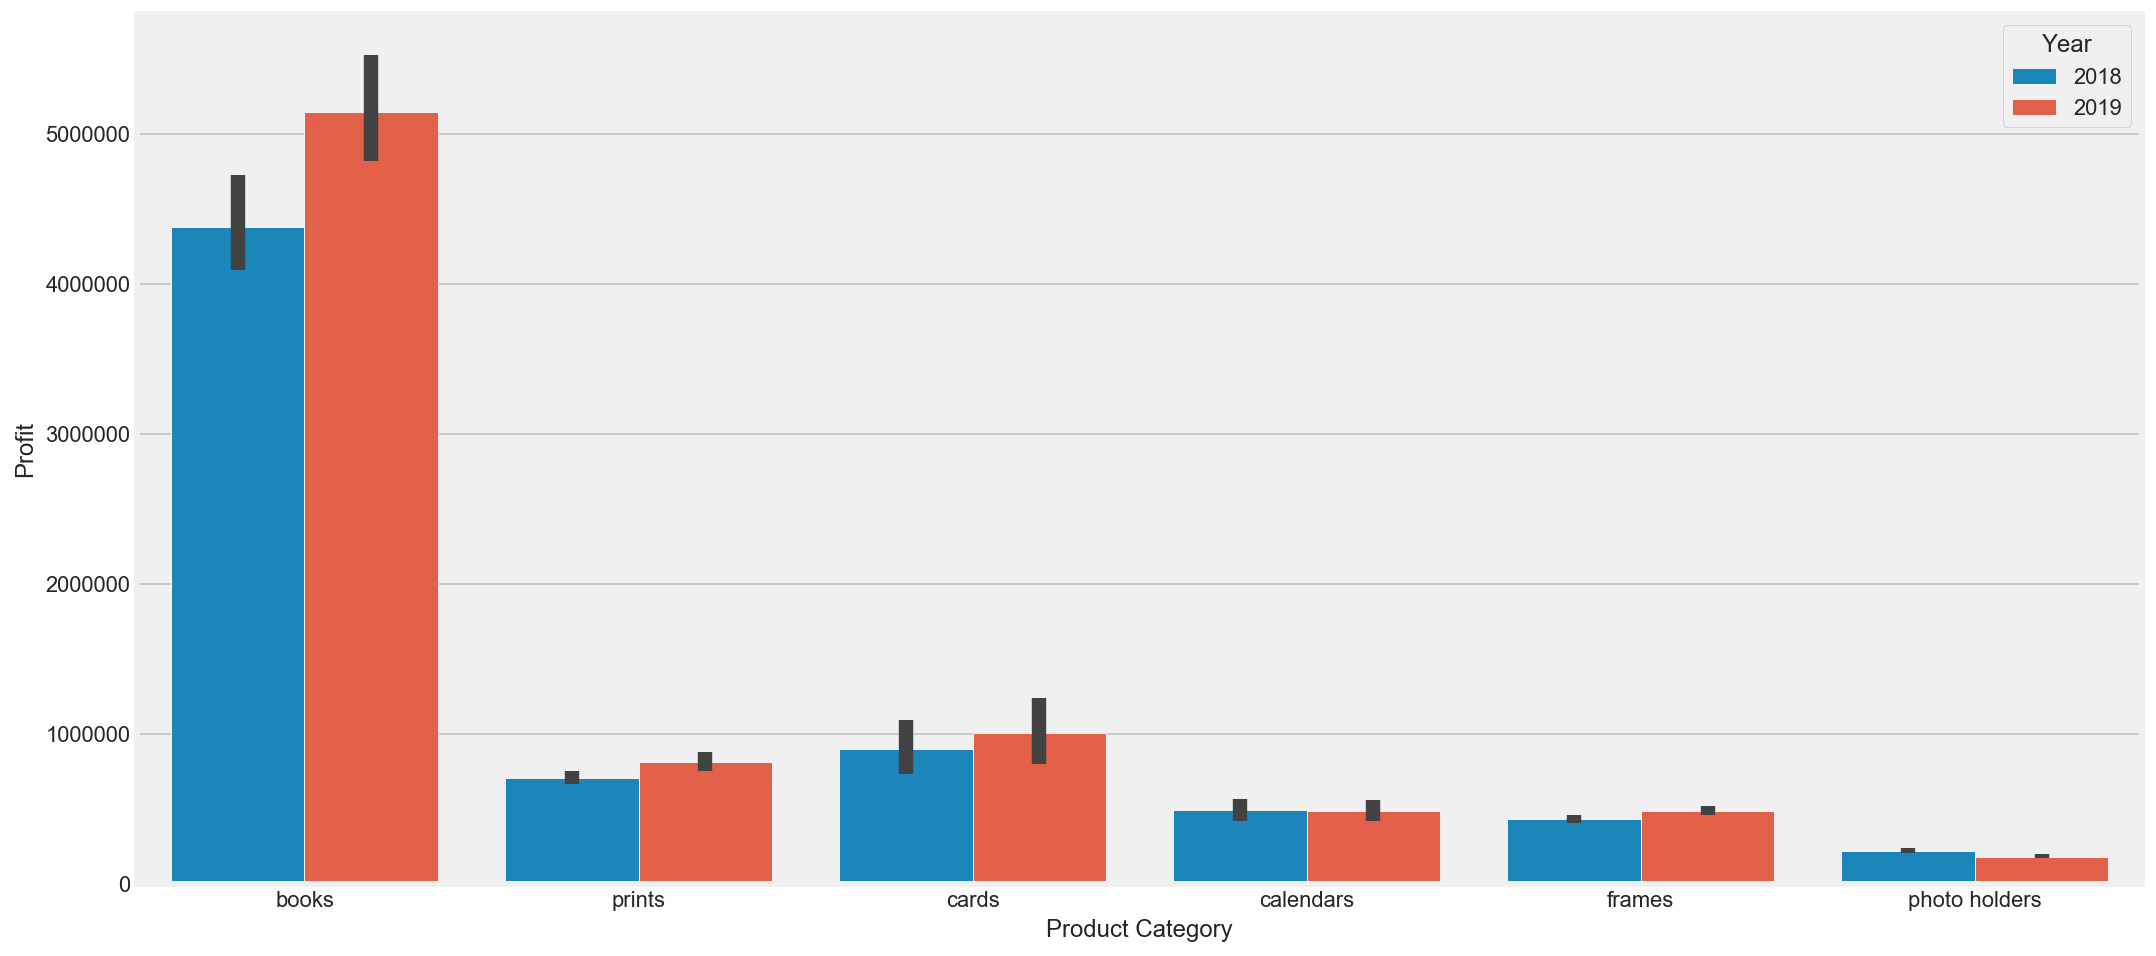

In [6]:
plt.figure(figsize=(16, 8))
sns.barplot(x='Product Category', y='Profit', hue='Year', estimator=np.sum, data=df)

# Year over Year Profit Ratio per Category

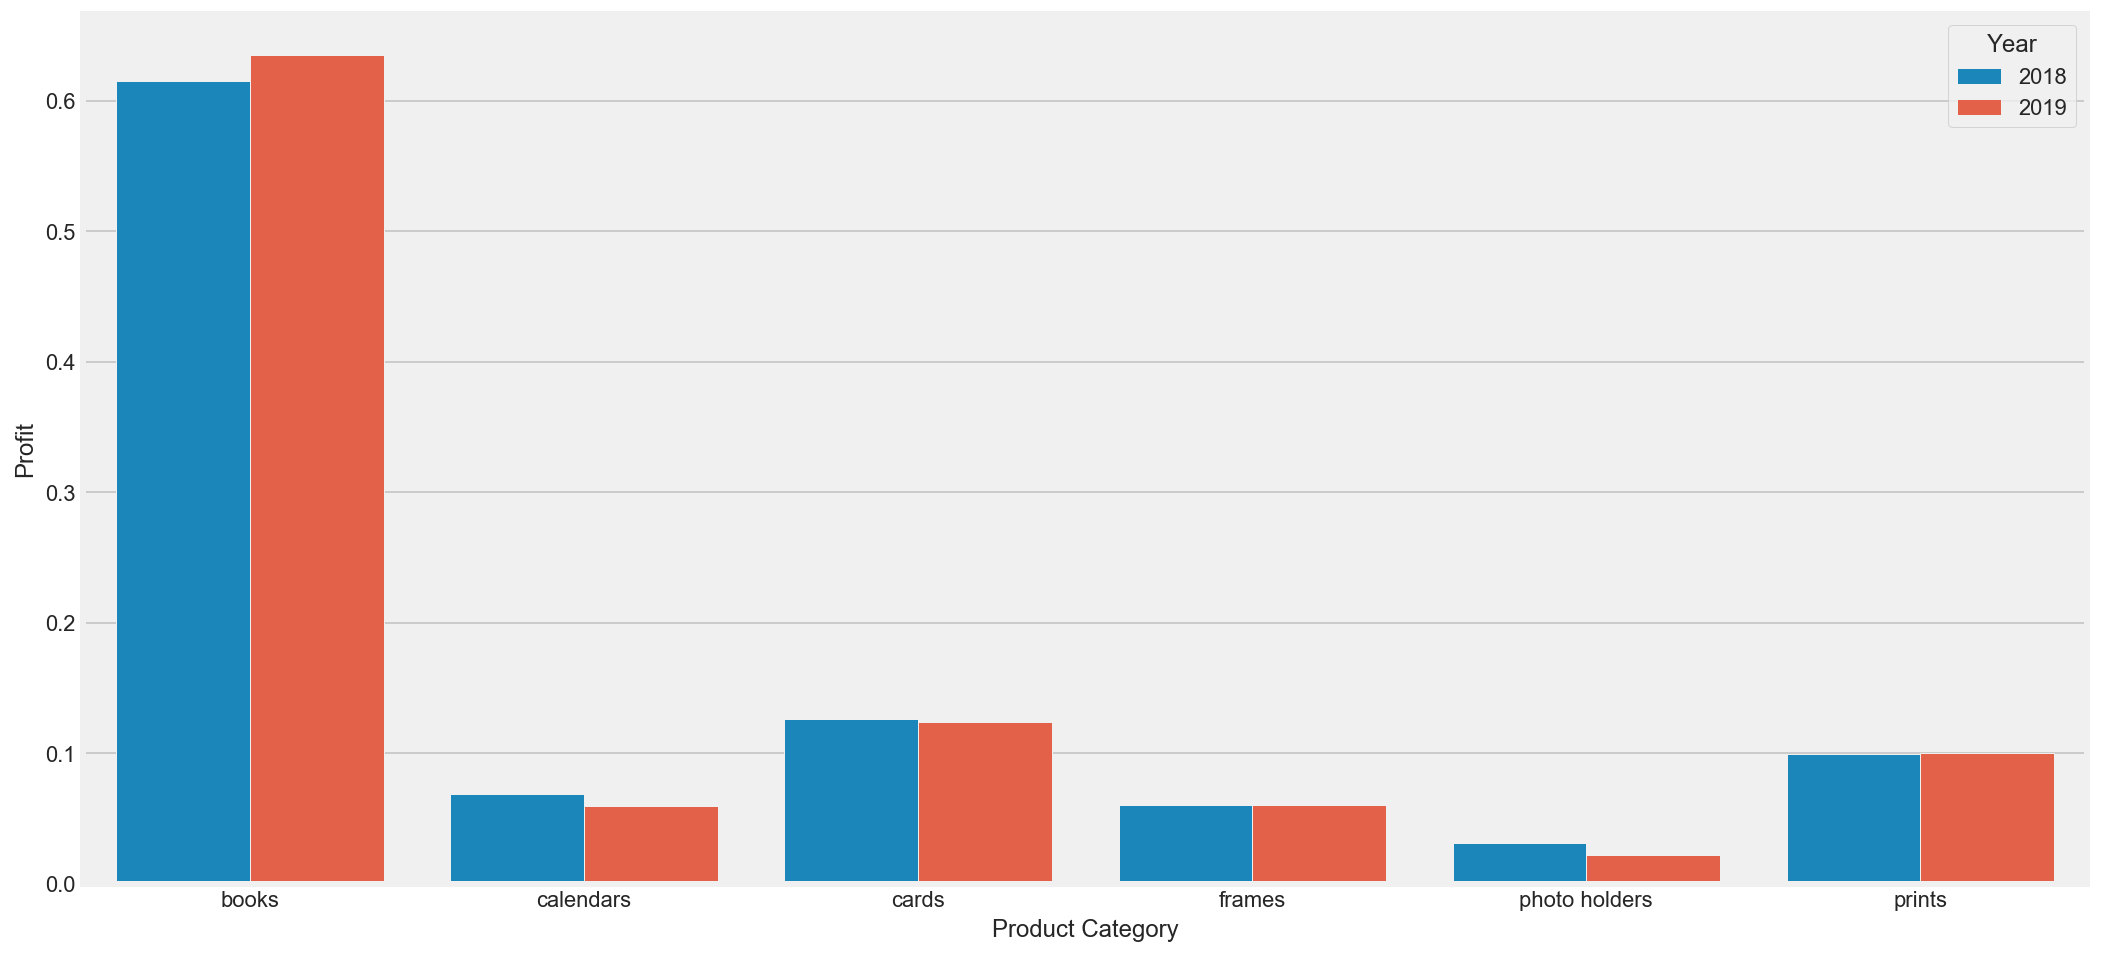

In [7]:
cat_rev = df.groupby(['Product Category','Year'])['Profit'].sum()
year_rev = df.groupby('Year')['Profit'].sum()
year_rev_ratio = cat_rev.div(year_rev).reset_index()
plt.figure(figsize=(16, 8))
sns.barplot(x='Product Category', y='Profit', hue='Year', data=year_rev_ratio)  

# 2019 Quarterly Profit by Product Category

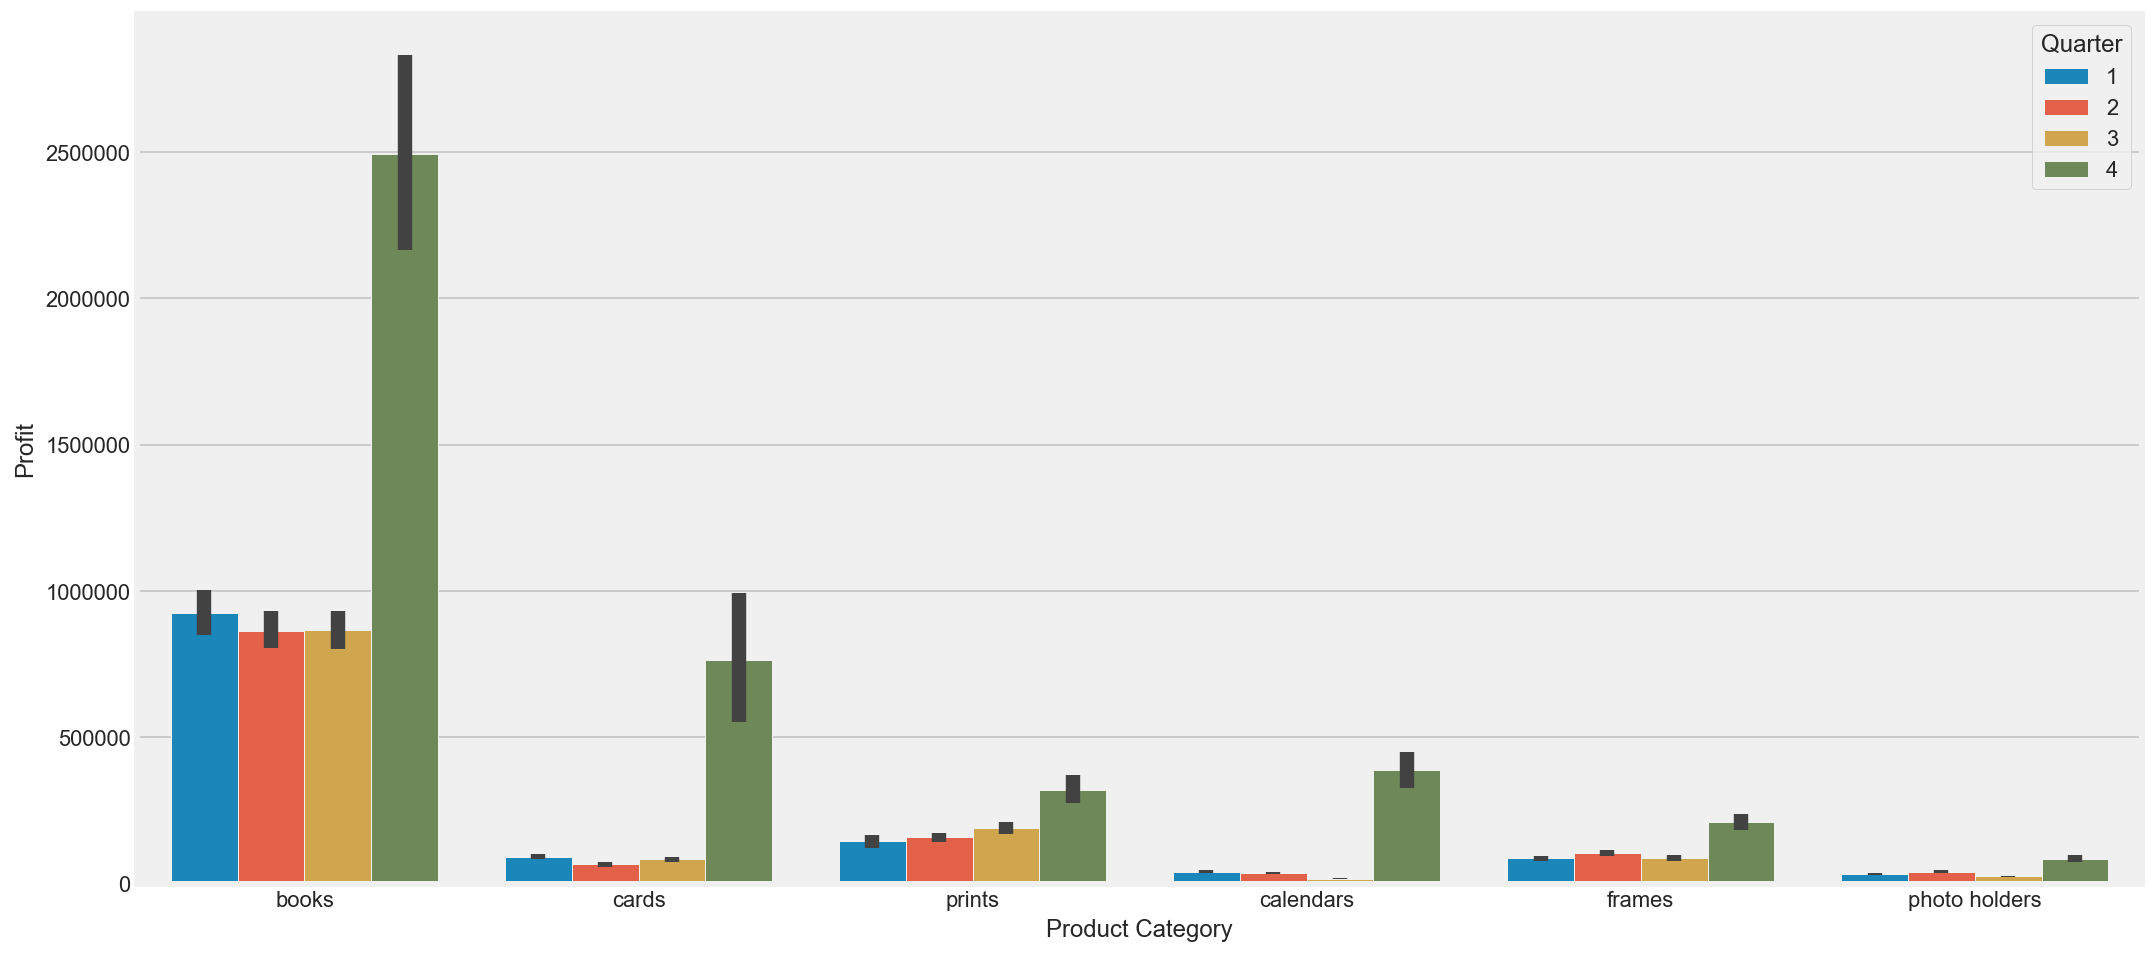

In [8]:
plt.figure(figsize=(16, 8))
sns.barplot(x='Product Category', y='Profit', hue='Quarter', estimator=np.sum, data=df[df['Year']==2019]) 

# Books Q4 percent of 2019 Profit

In [9]:
df[(df['Quarter']==4)&(df['Year']==2019)&(df['Product Category']=='books')]['Profit'].sum() / df[df['Year']==2019]['Profit'].sum()

0.30753730632563103

# Which book product lines are driving the most profit?

[Text(0, 0, 'hardcover photo books'),
 Text(0, 0, 'layflat photo albums'),
 Text(0, 0, 'softcover photo books'),
 Text(0, 0, 'everyday print set'),
 Text(0, 0, 'wedding guest books'),
 Text(0, 0, 'holiday cards'),
 Text(0, 0, 'baby book'),
 Text(0, 0, 'brass easel calendars'),
 Text(0, 0, 'wood calendars'),
 Text(0, 0, 'large format prints')]

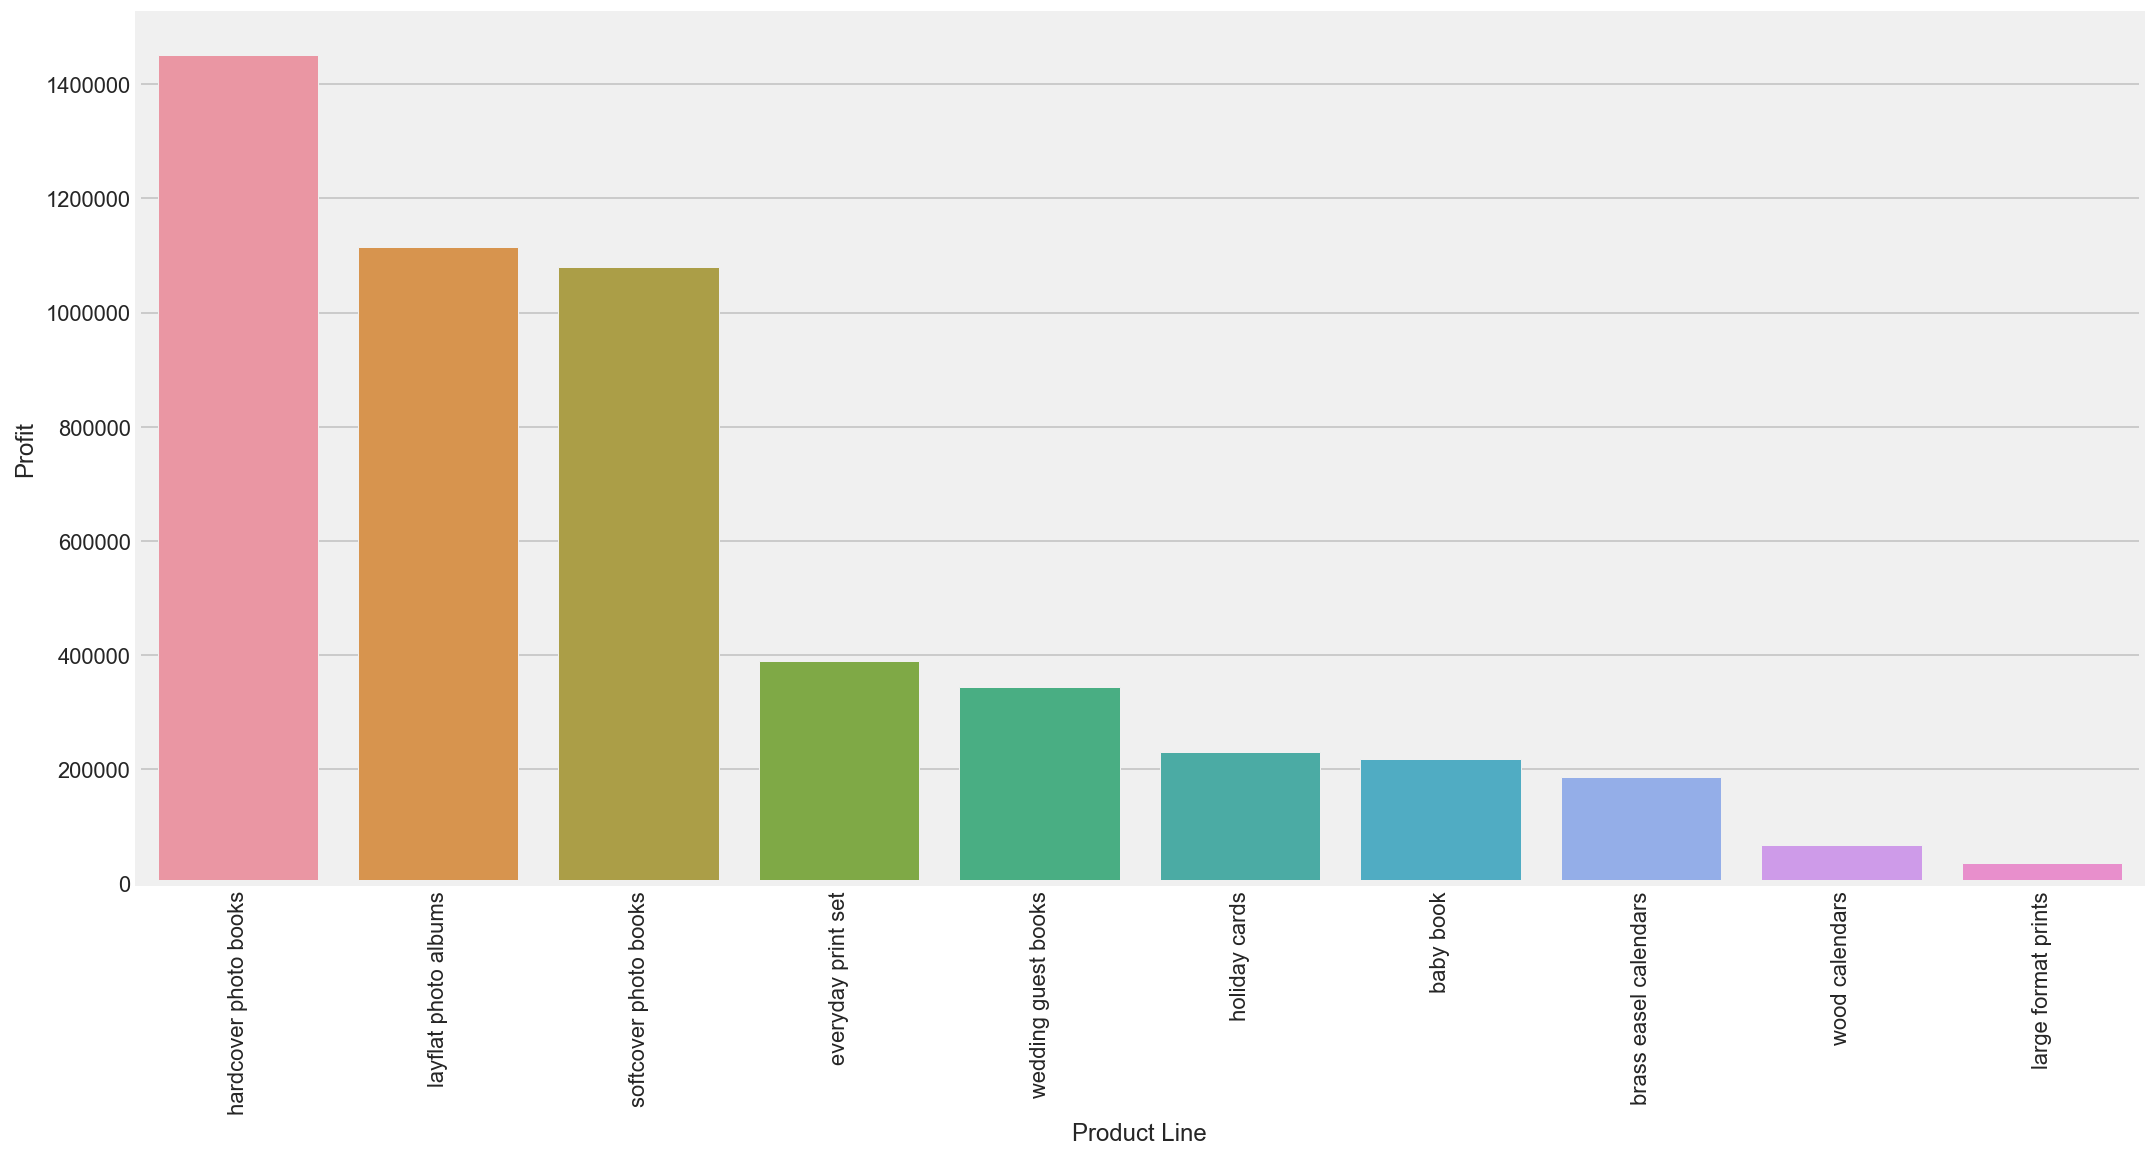

In [10]:
book_profits = df[(df['Year']==2019)&(df['Product Category']=='books')].groupby('Product Line')['Profit'].sum().sort_values(ascending=False).reset_index()
plt.figure(figsize=(16, 8))
g = sns.barplot(x='Product Line',y='Profit',data=book_profits[:10])
g.set_xticklabels(df[:10]['Product Line'], rotation=90)

In [11]:
line_profits = df[(df['Year']==2019)&(df['Product Category']=='books')].groupby('Product Line')['Profit'].sum()
book_profit = df[(df['Year']==2019)&(df['Product Category']=='books')]['Profit'].sum()
line_profits.div(book_profit).sort_values(ascending=False)

Product Line
hardcover photo books               0.282017
layflat photo albums                0.216784
wedding layflat photo albums        0.209938
everyday photo books                0.075869
softcover photo books               0.066879
wedding guest books                 0.044848
baby book                           0.042420
color series photo book             0.036333
baby board book                     0.013185
wedding guest book set              0.006854
wedding album design service fee    0.002472
baby book refill pack               0.001530
scrapbook album                     0.001089
volumes subscription series         0.000004
dust jacket refill                 -0.000220
Name: Profit, dtype: float64

# Correlation Matrix

In [12]:
#correlation heatmap of dataset
def correlation_heatmap(df):
    _ , ax = plt.subplots(figsize =(14, 12))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)
    
    _ = sns.heatmap(
        df.corr(), 
        cmap = colormap,
        square=True, 
        cbar_kws={'shrink':.9 }, 
        ax=ax,
        annot=True, 
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':12 }
    )
    
    plt.title('Pearson Correlation of Features', y=1.05, size=15)

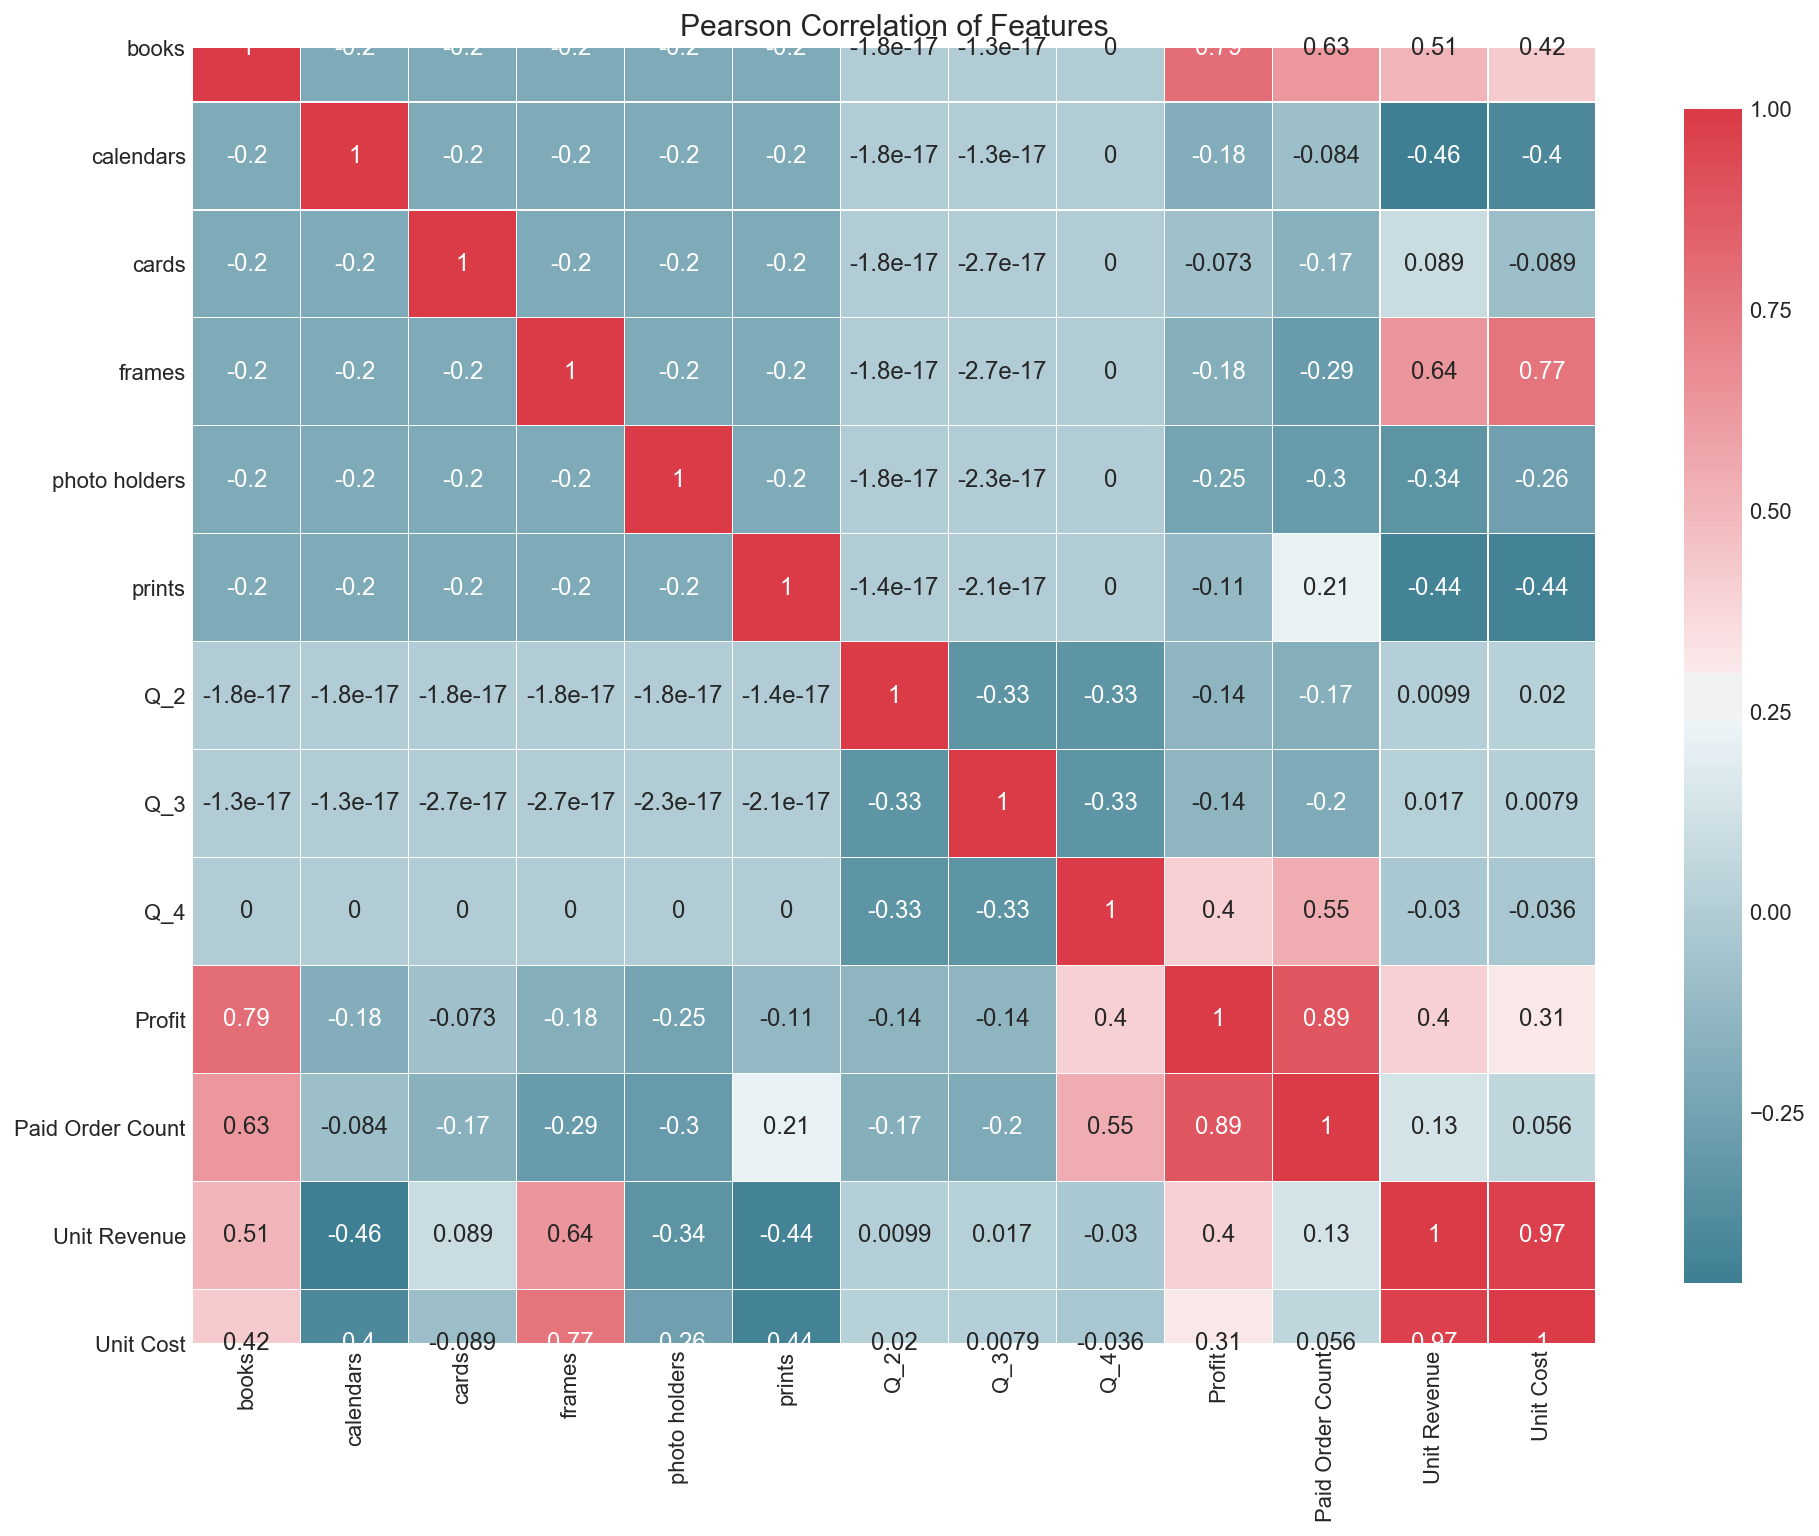

In [13]:
corr_df = df[df['Year']==2019].groupby(['Product Category','Quarter']).agg({'Profit':np.sum, 'Paid Order Count':np.sum,'Unit Revenue':np.mean, 'Unit Cost':np.mean}).reset_index()
quarter_dummies = pd.get_dummies(corr_df['Quarter'], prefix='Q', drop_first=True)
cat_dummies = pd.get_dummies(corr_df['Product Category'], drop_first=False)
corr_df = pd.concat([cat_dummies,quarter_dummies, corr_df[['Profit','Paid Order Count','Unit Revenue','Unit Cost']]], axis=1)
correlation_heatmap(corr_df)

# Look at relationship between costs, units sold, and revenue

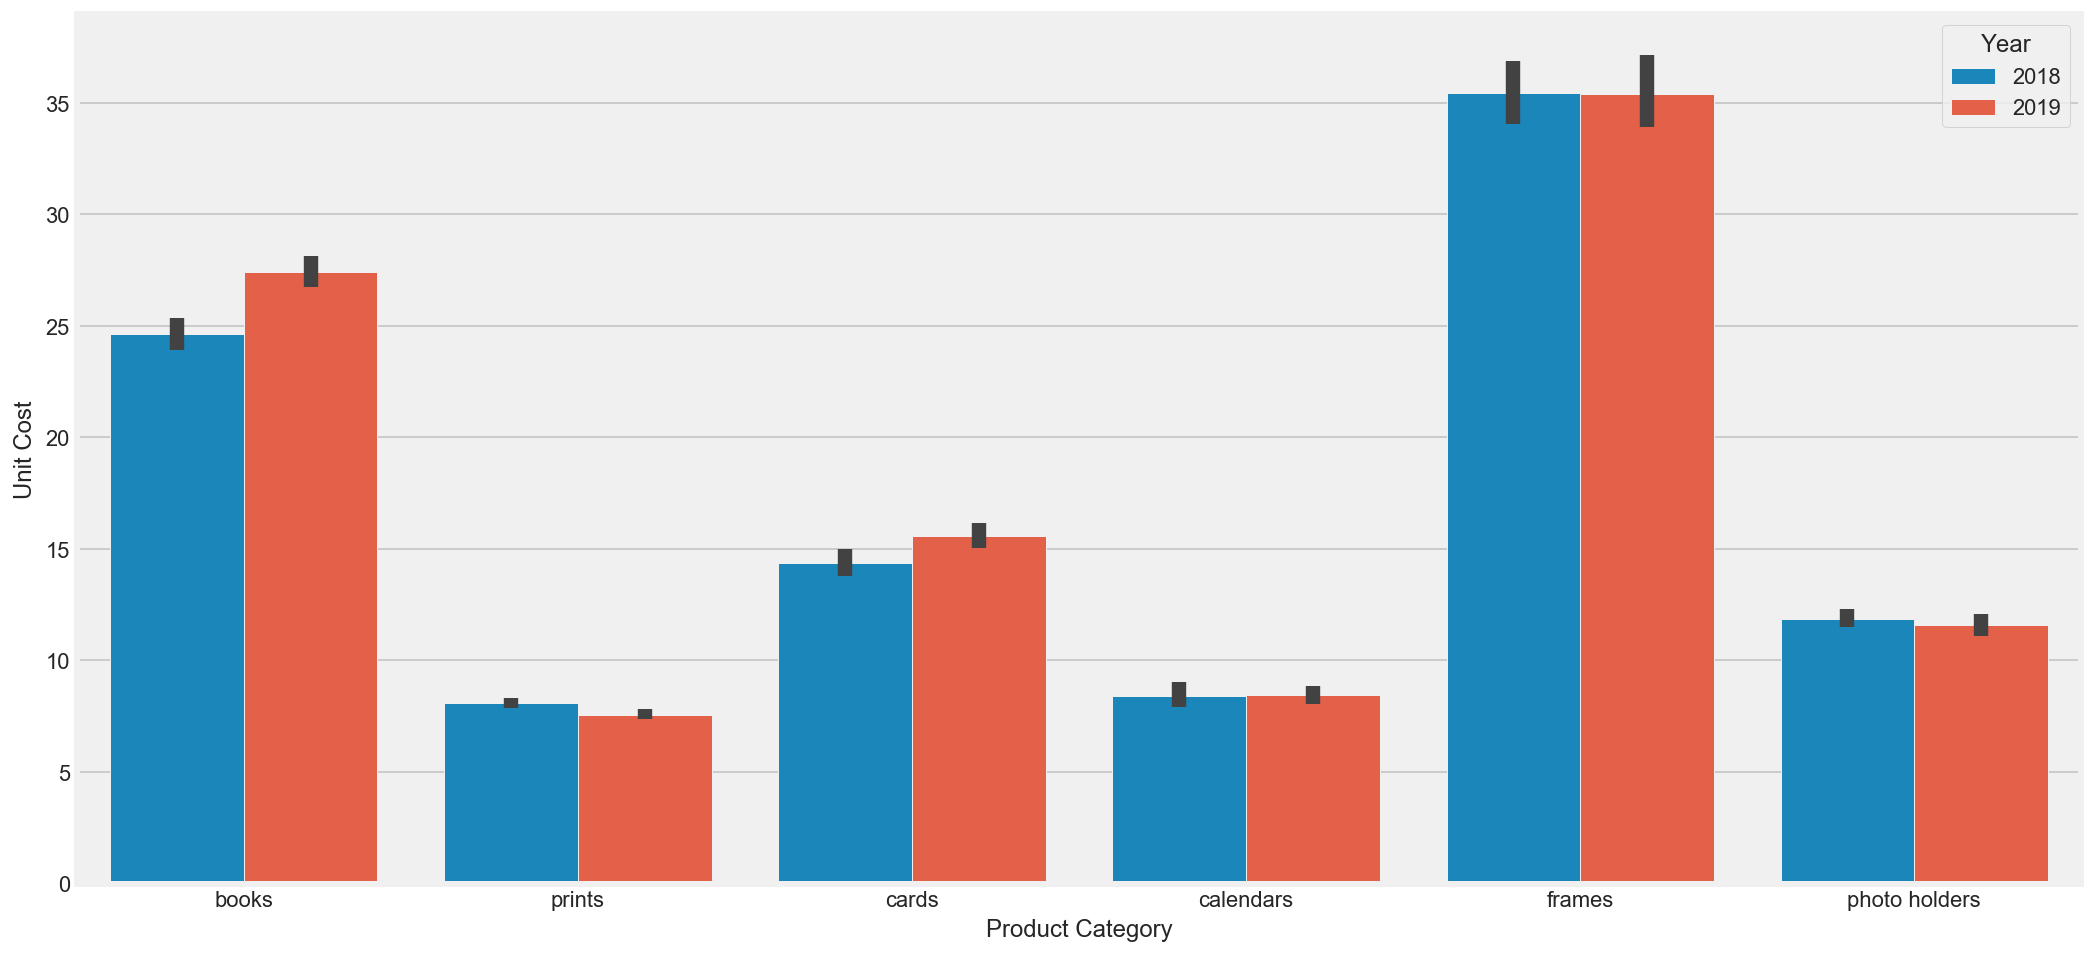

In [14]:
plt.figure(figsize=(16, 8))
sns.barplot(x='Product Category', y='Unit Cost', hue='Year', estimator=np.mean, data=df)

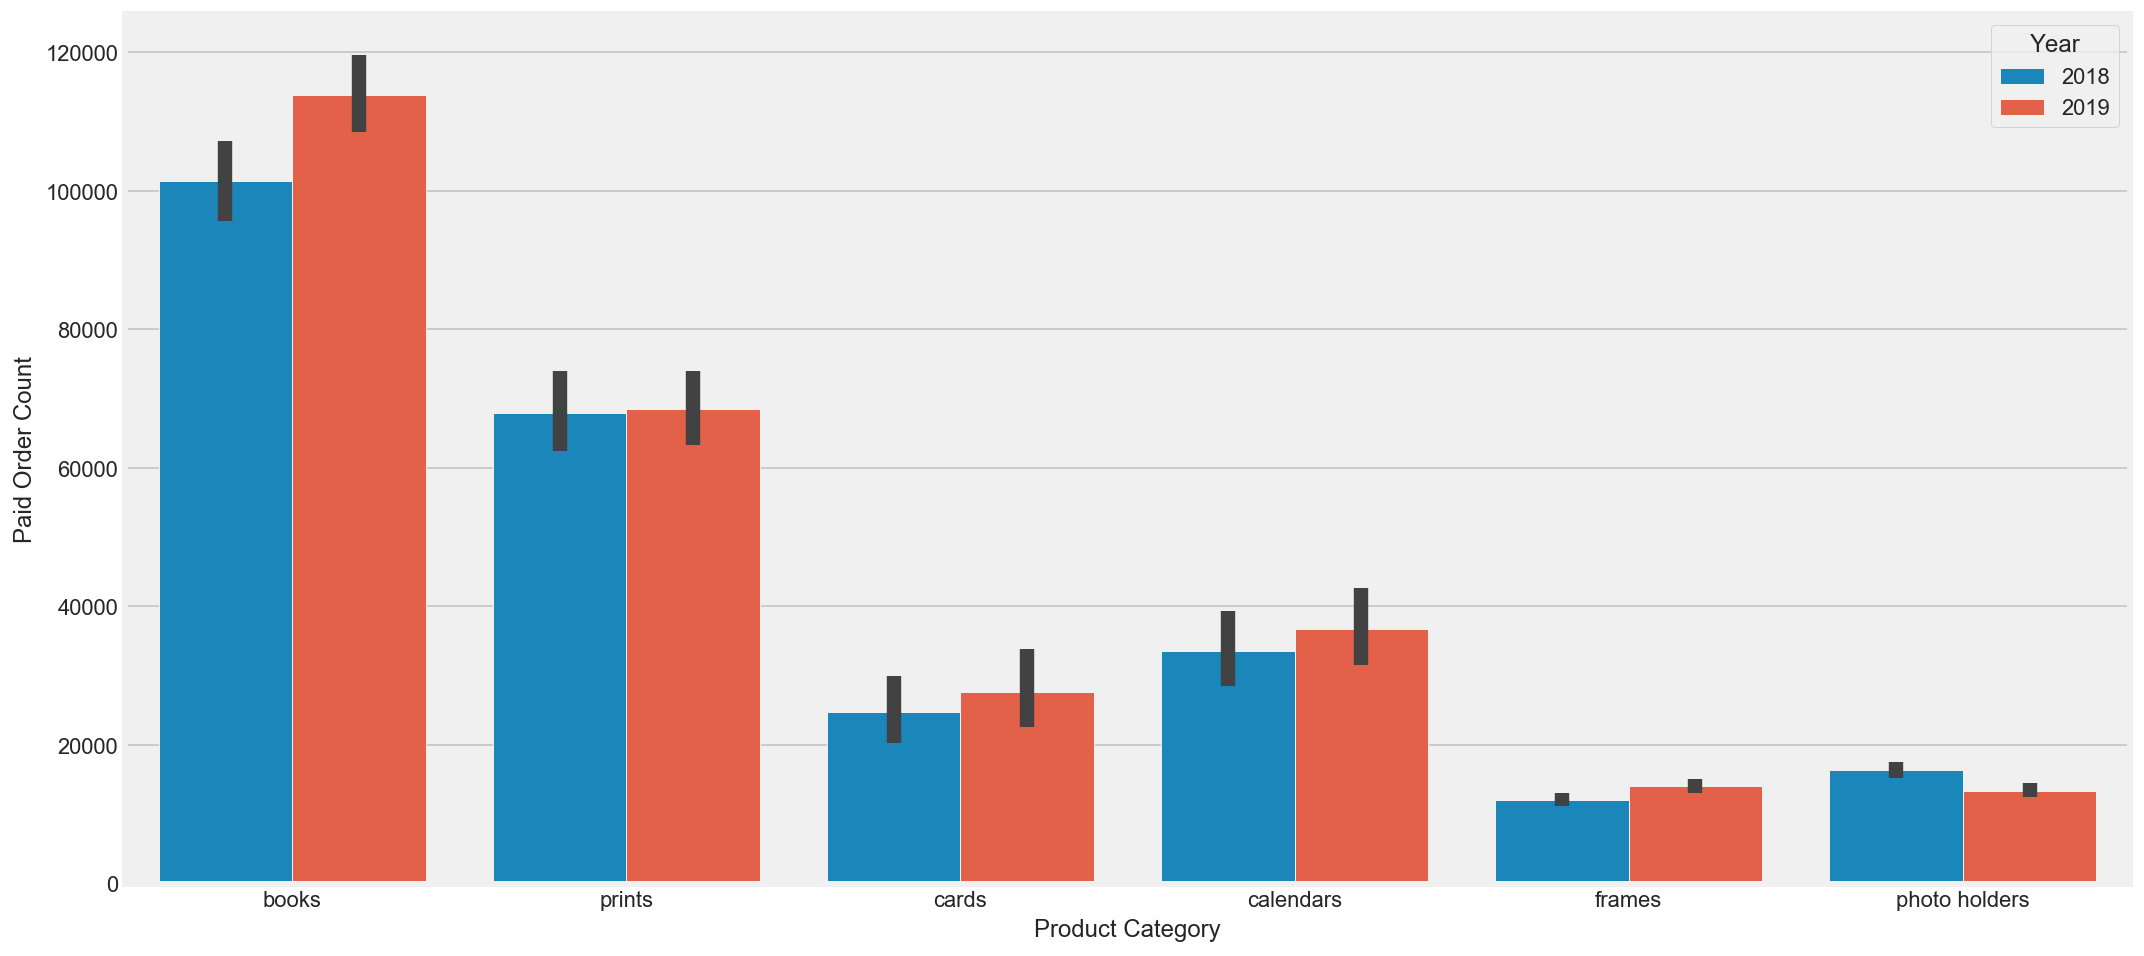

In [15]:
plt.figure(figsize=(16, 8))
sns.barplot(x='Product Category', y='Paid Order Count', hue='Year', estimator=np.sum, data=df)

# Time Series & Trend Analysis

In [16]:
weekly_orders = df.groupby(['Product Category', pd.Grouper(key='Date',freq='W')])['Paid Order Count'].sum().reset_index()
daily_orders = df.groupby(['Product Category', pd.Grouper(key='Date',freq='D')])['Paid Order Count'].sum().reset_index()

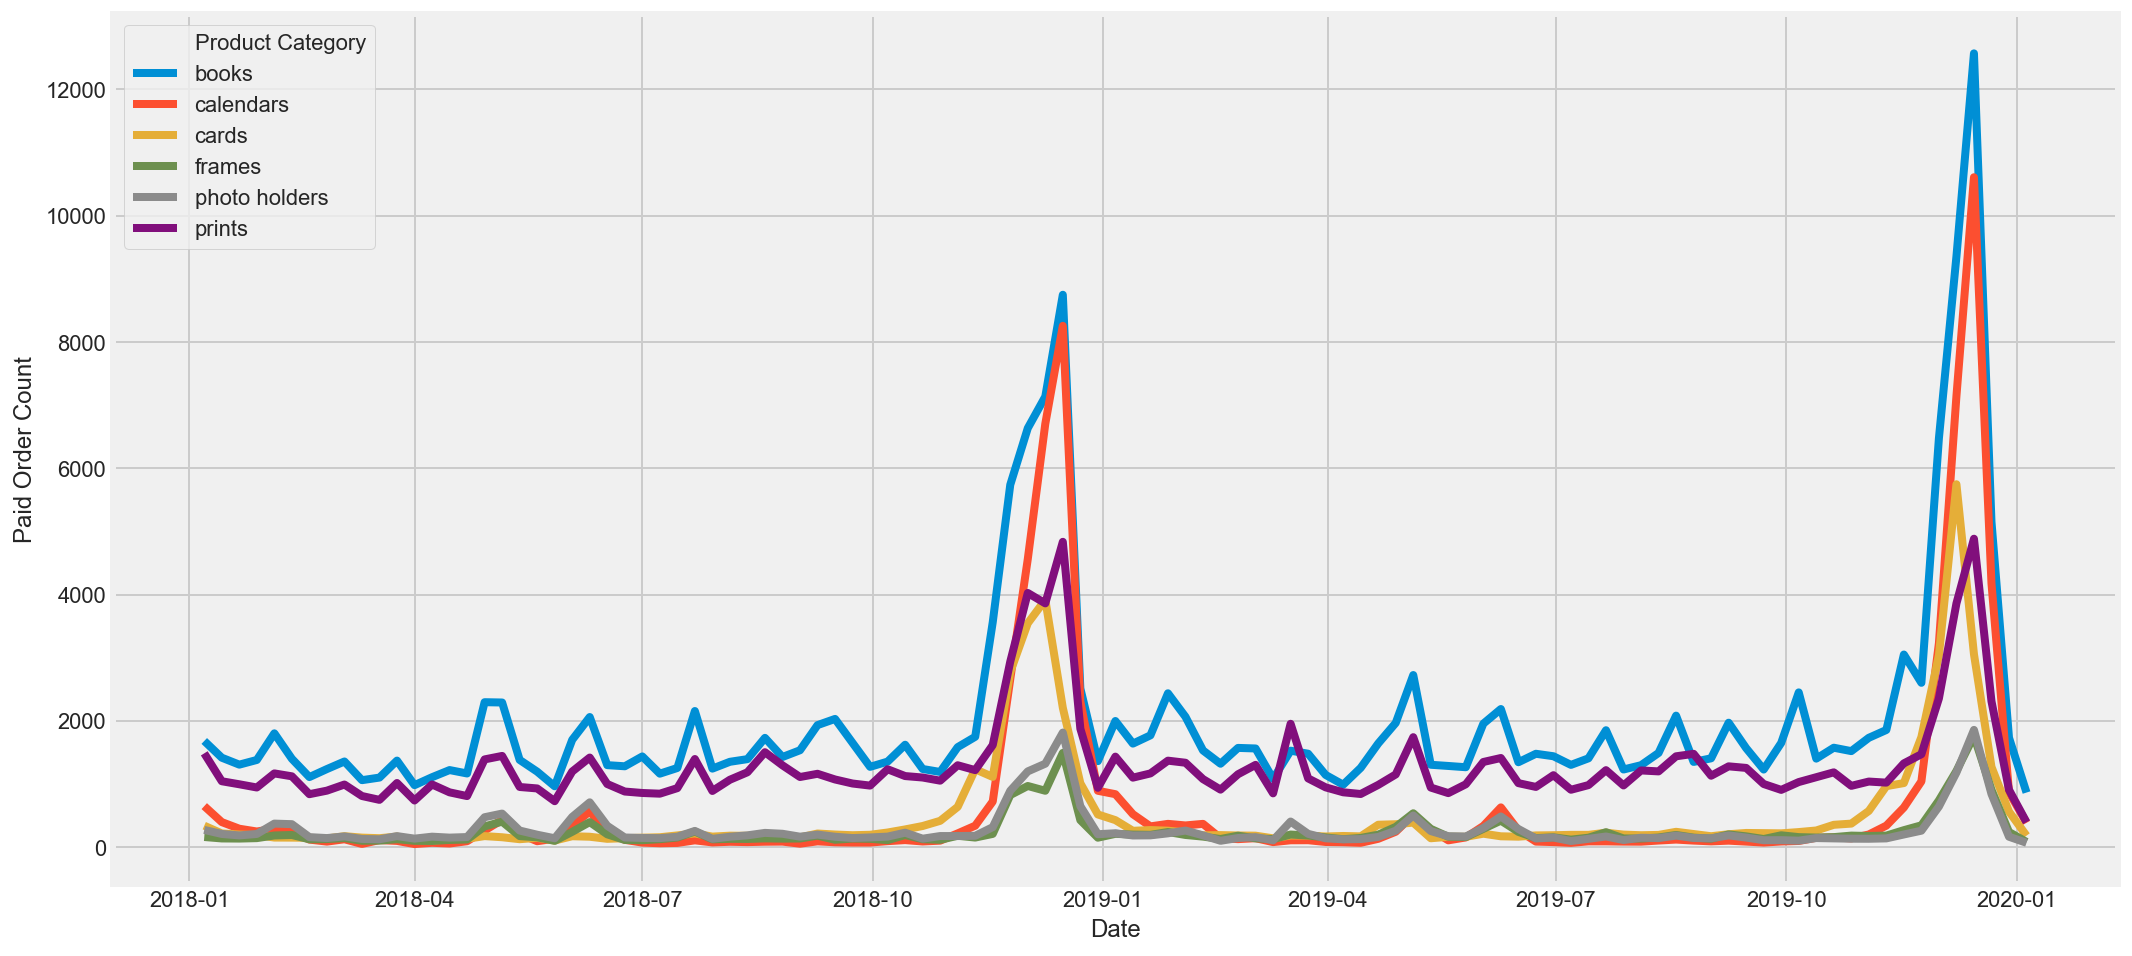

In [17]:
plt.figure(figsize=(16, 8))
sns.lineplot(x='Date',y='Paid Order Count', hue='Product Category', data=weekly_orders)

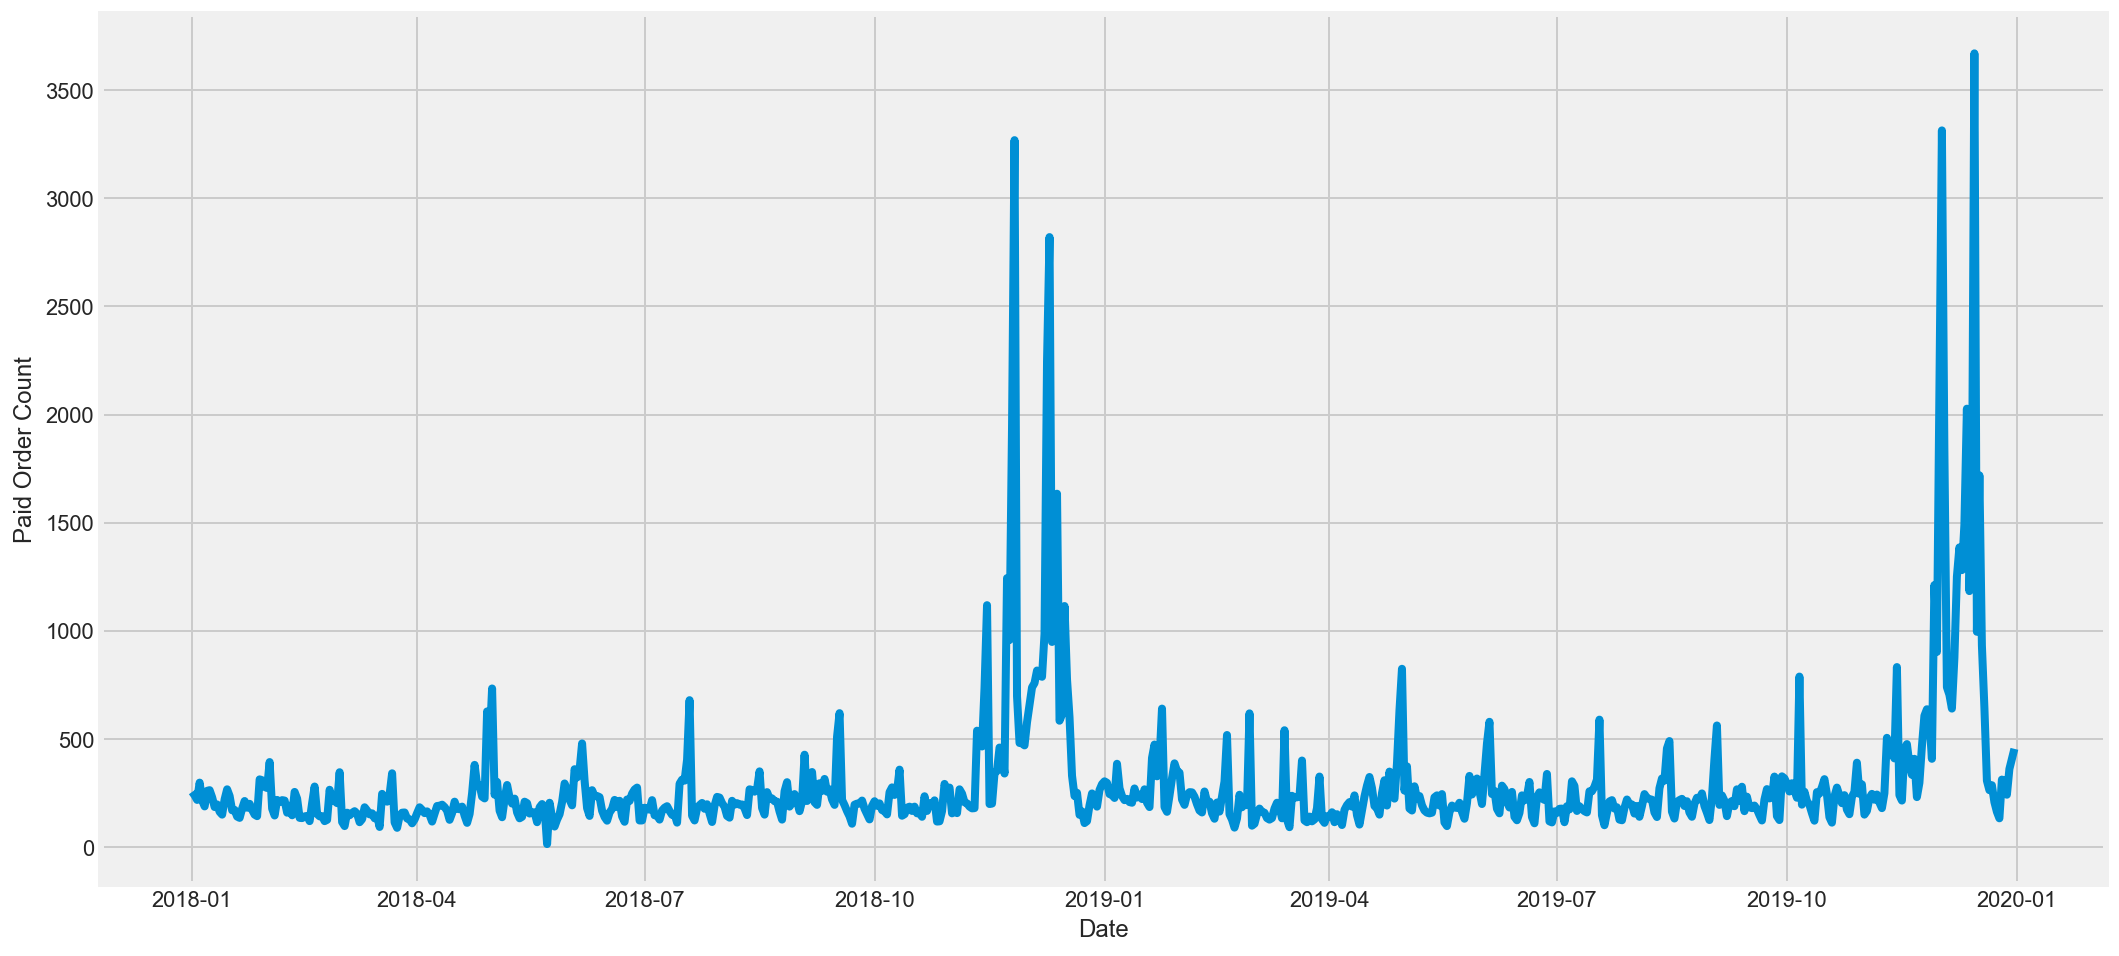

In [18]:
plt.figure(figsize=(16, 8))
sns.lineplot(x='Date',y='Paid Order Count', data=daily_orders[daily_orders['Product Category']=='books'])

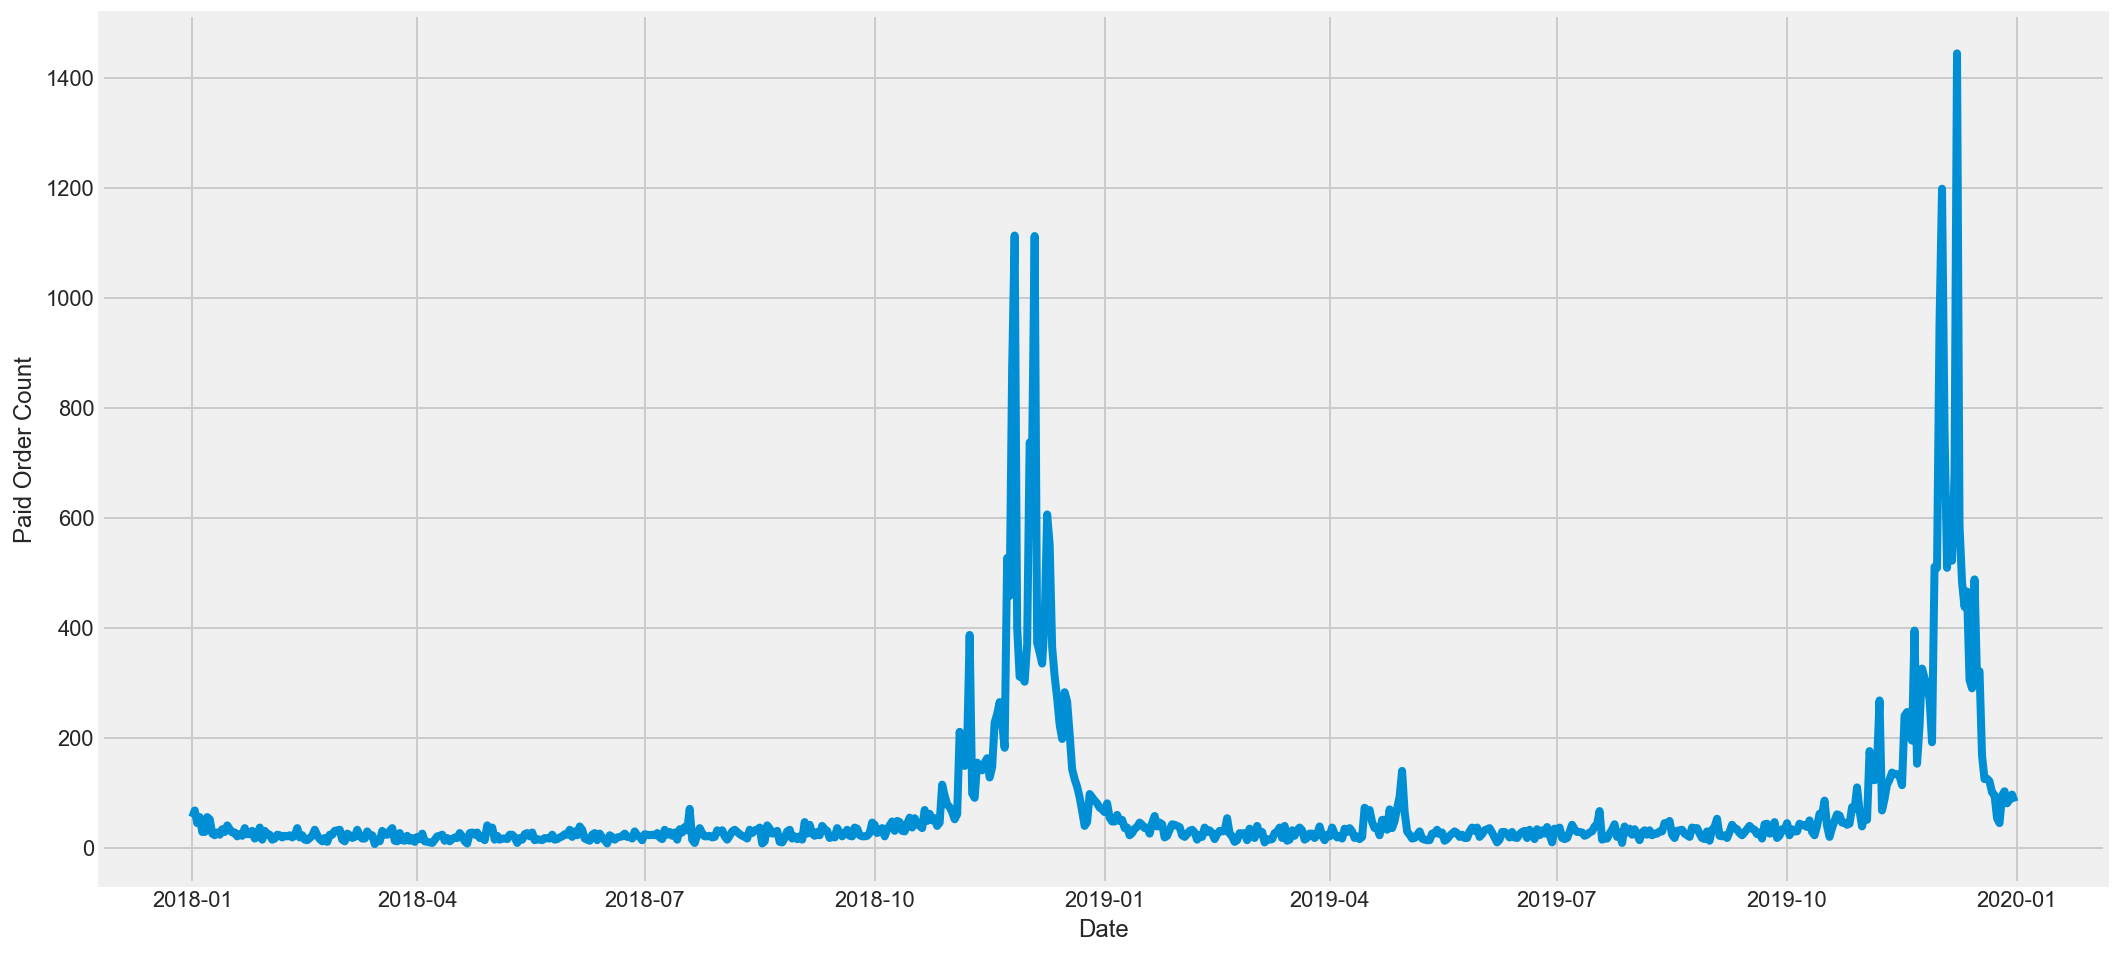

In [19]:
plt.figure(figsize=(16, 8))
sns.lineplot(x='Date',y='Paid Order Count', data=daily_orders[daily_orders['Product Category']=='cards'])

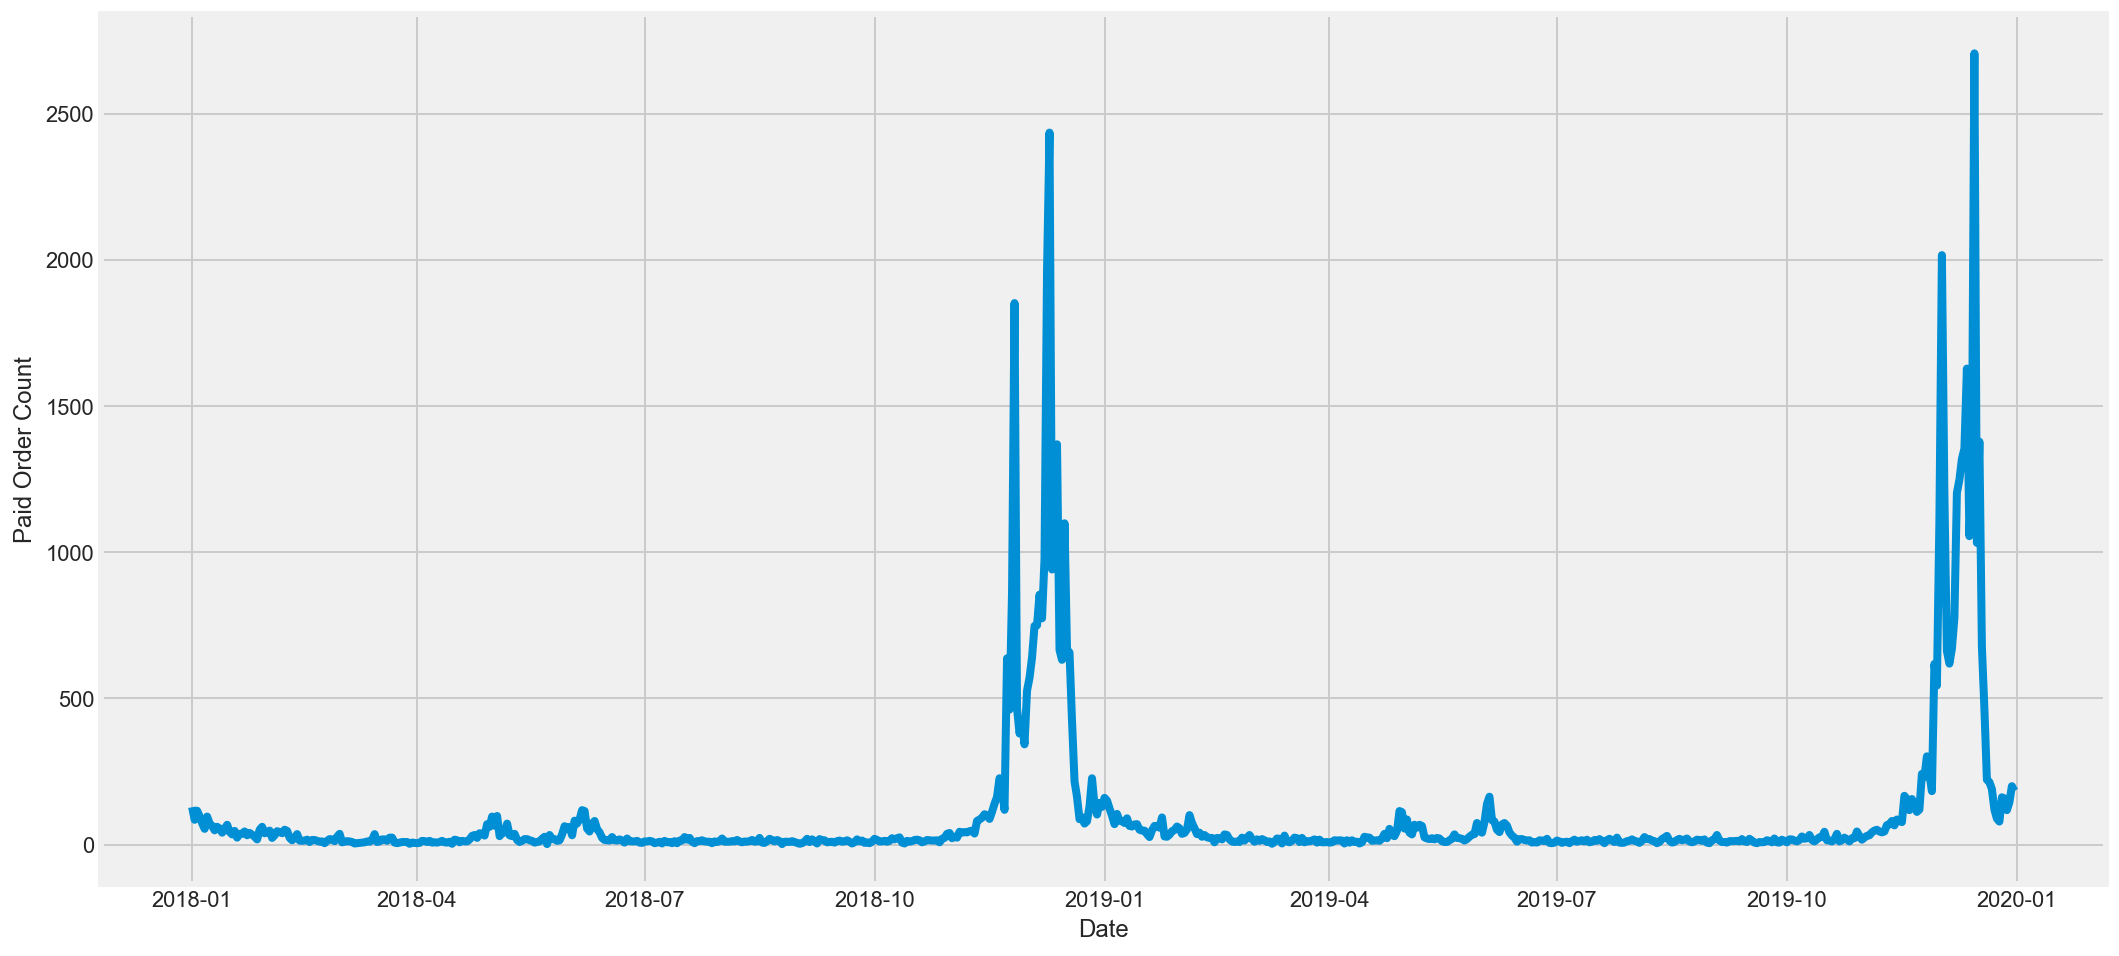

In [20]:
plt.figure(figsize=(16, 8))
sns.lineplot(x='Date',y='Paid Order Count', data=daily_orders[daily_orders['Product Category']=='calendars'])

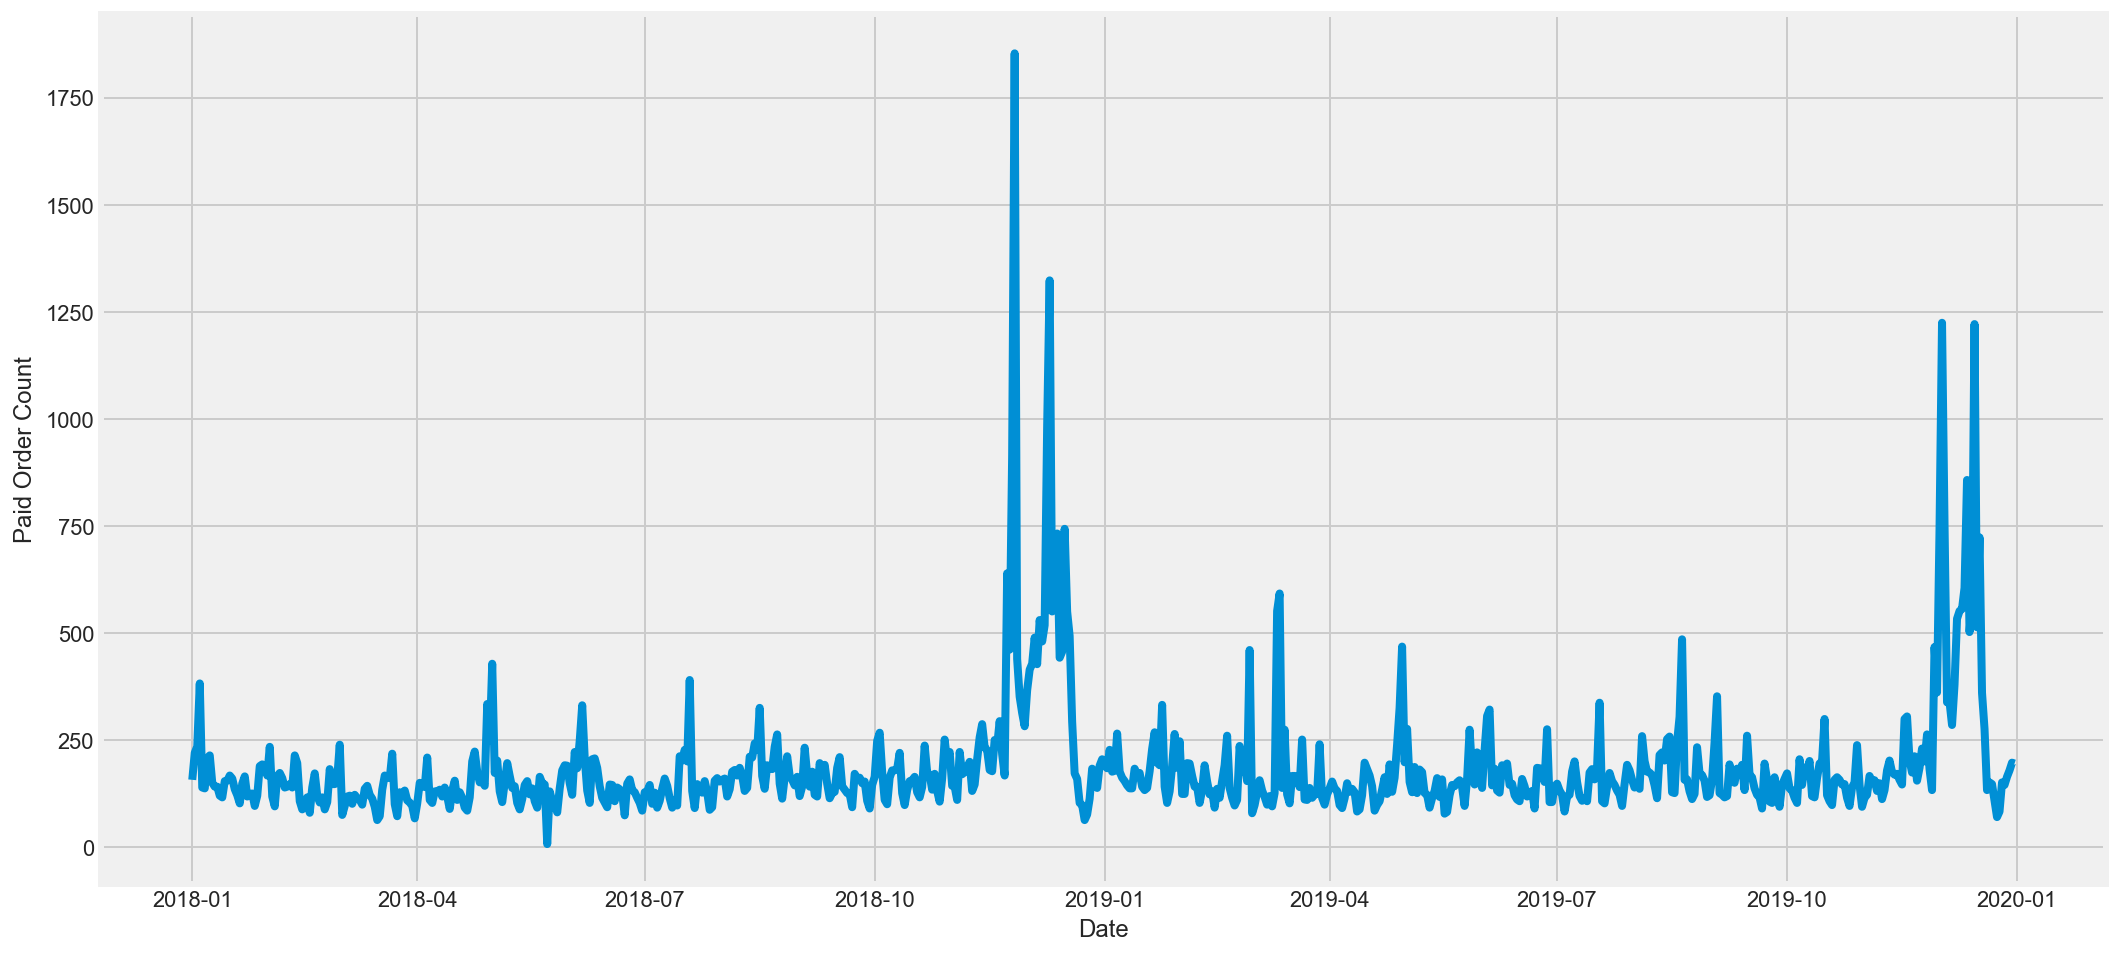

In [21]:
plt.figure(figsize=(16, 8))
sns.lineplot(x='Date',y='Paid Order Count', data=daily_orders[daily_orders['Product Category']=='prints'])

# Order Distributions by Category

In [22]:
daily_books = daily_orders[daily_orders['Product Category']=='books'][['Date','Paid Order Count']].set_index('Date')
daily_cards = daily_orders[daily_orders['Product Category']=='cards'][['Date','Paid Order Count']].set_index('Date')
daily_calendars = daily_orders[daily_orders['Product Category']=='calendars'][['Date','Paid Order Count']].set_index('Date')
daily_prints = daily_orders[daily_orders['Product Category']=='prints'][['Date','Paid Order Count']].set_index('Date')

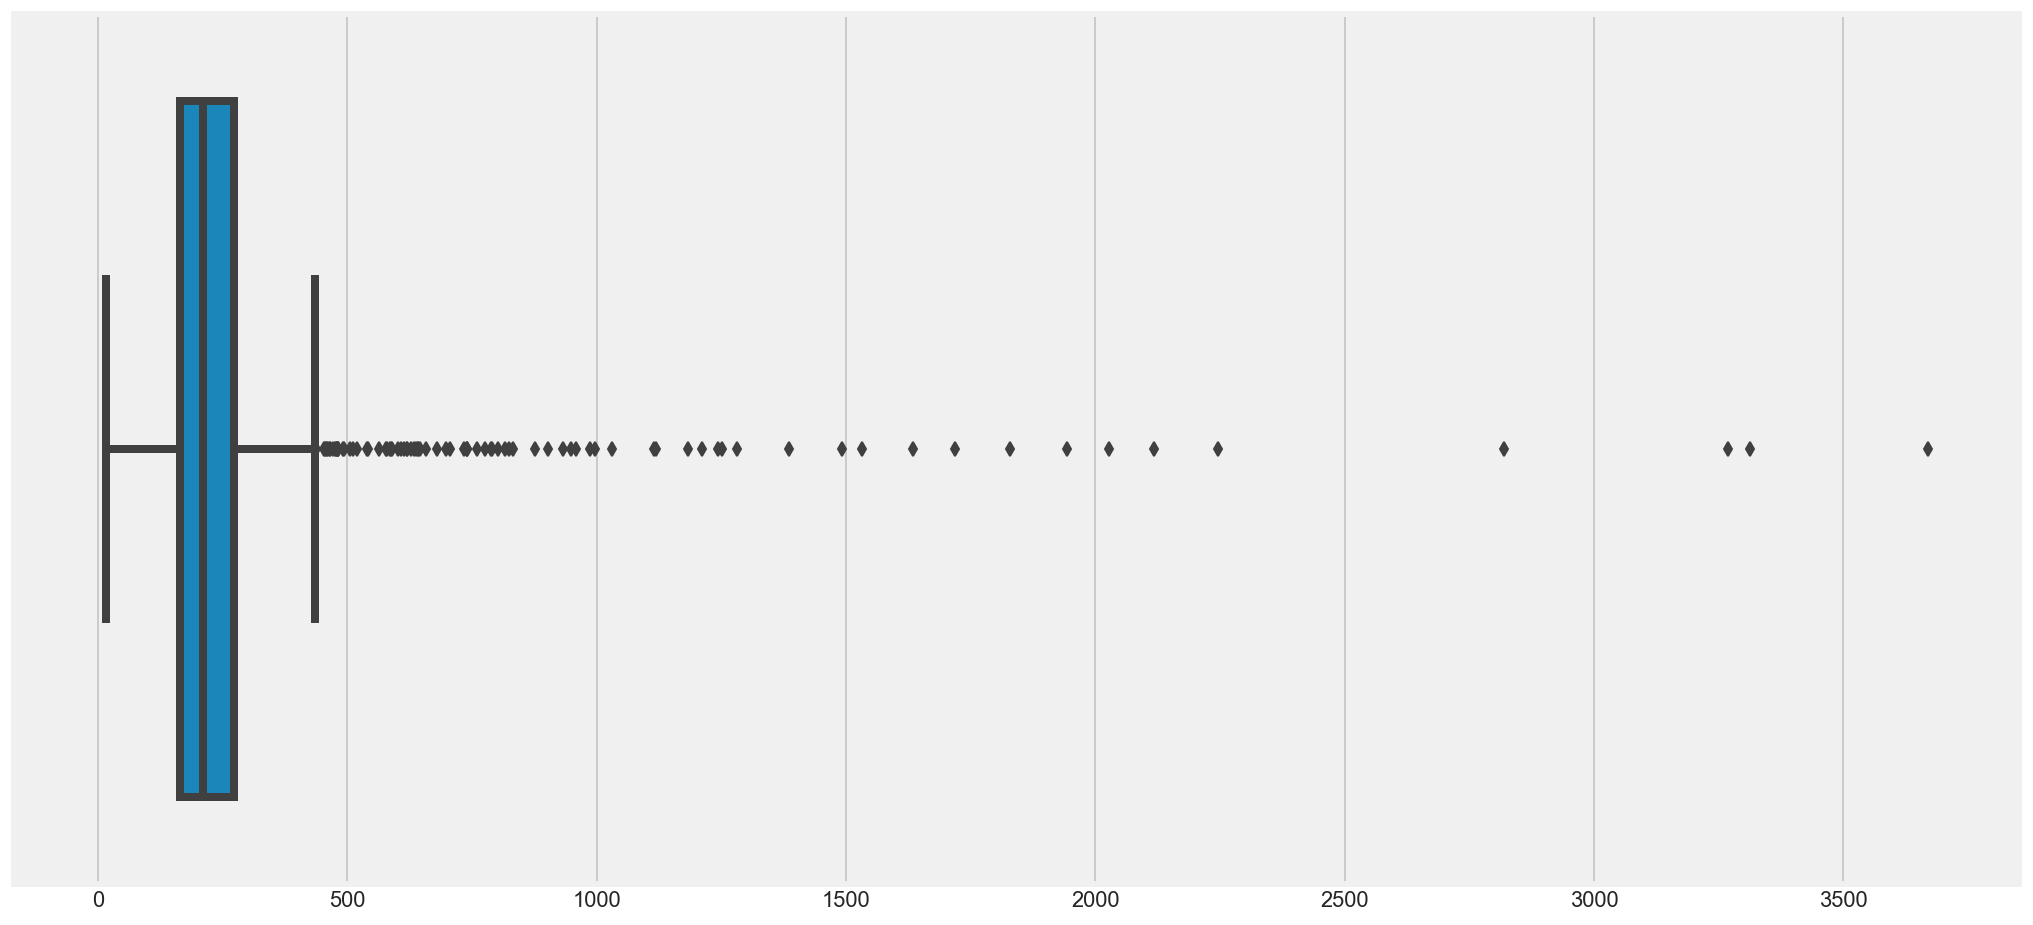

In [23]:
plt.figure(figsize=(16, 8))
sns.boxplot(daily_books)

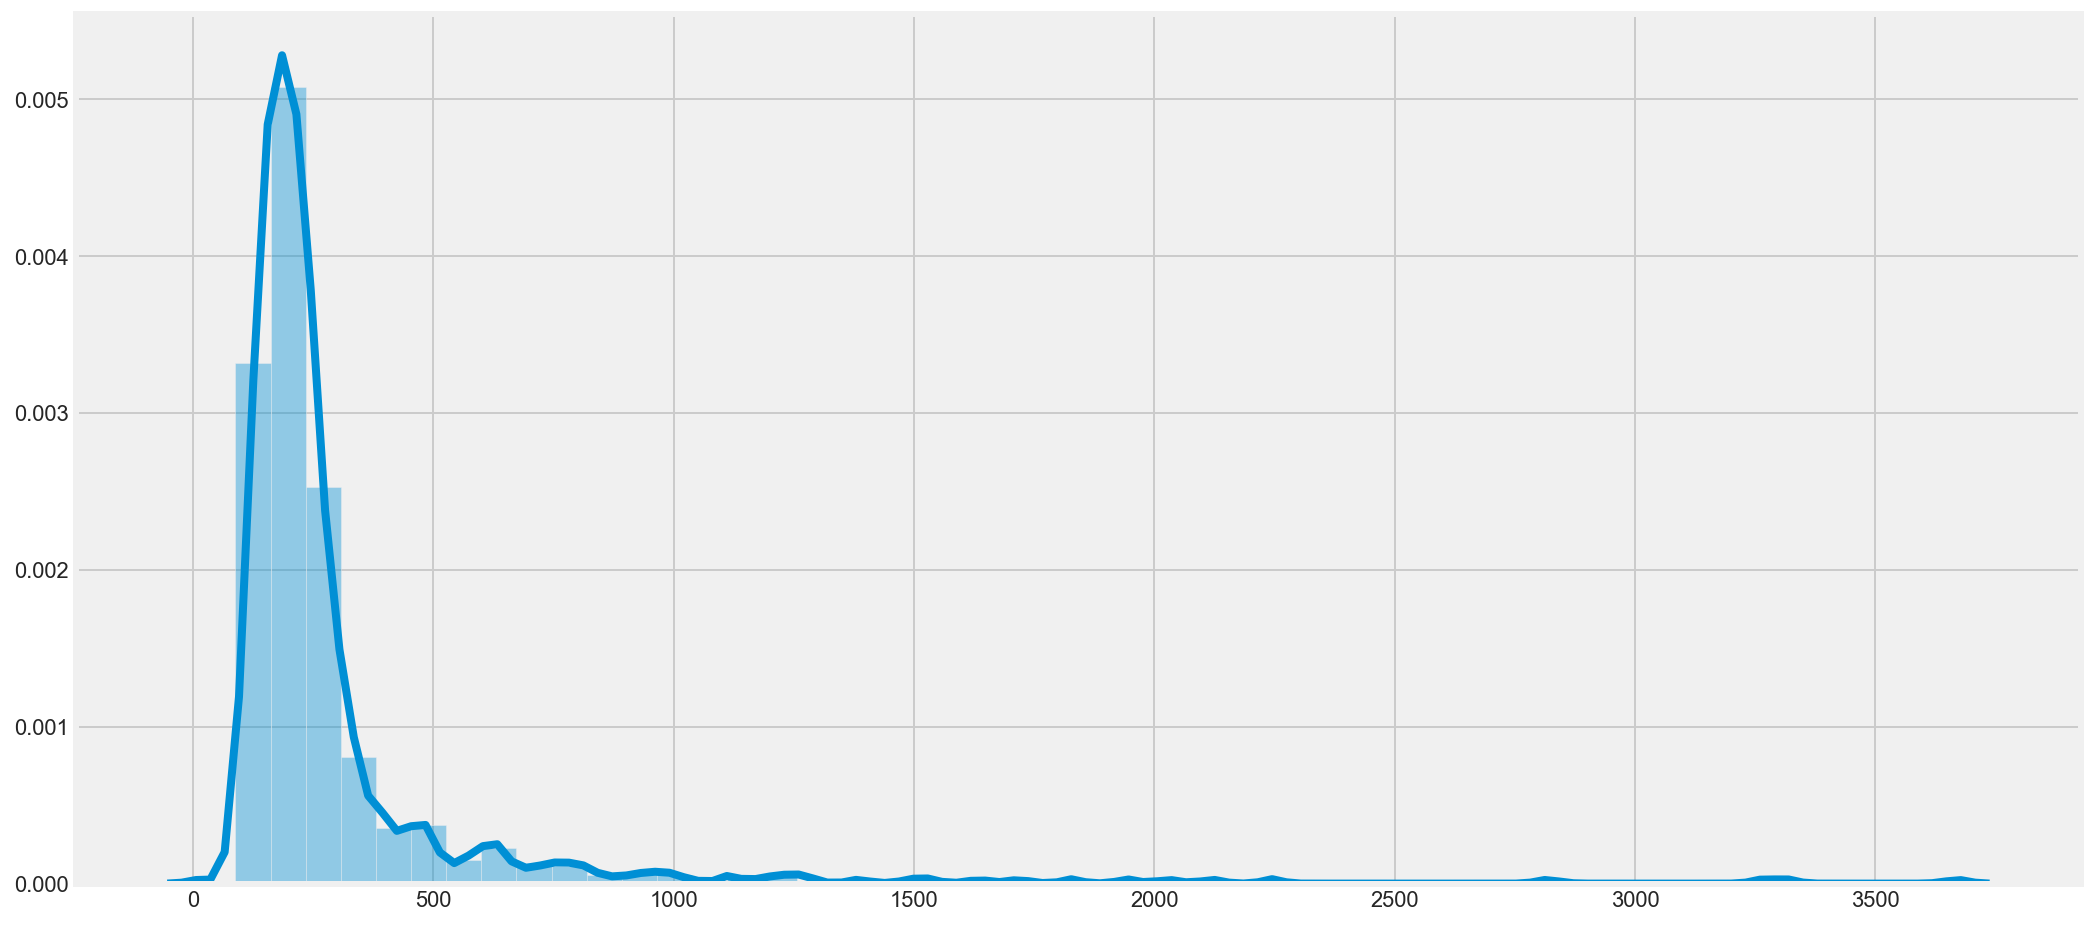

In [24]:
plt.figure(figsize=(16, 8))
sns.distplot(daily_books, bins=50)

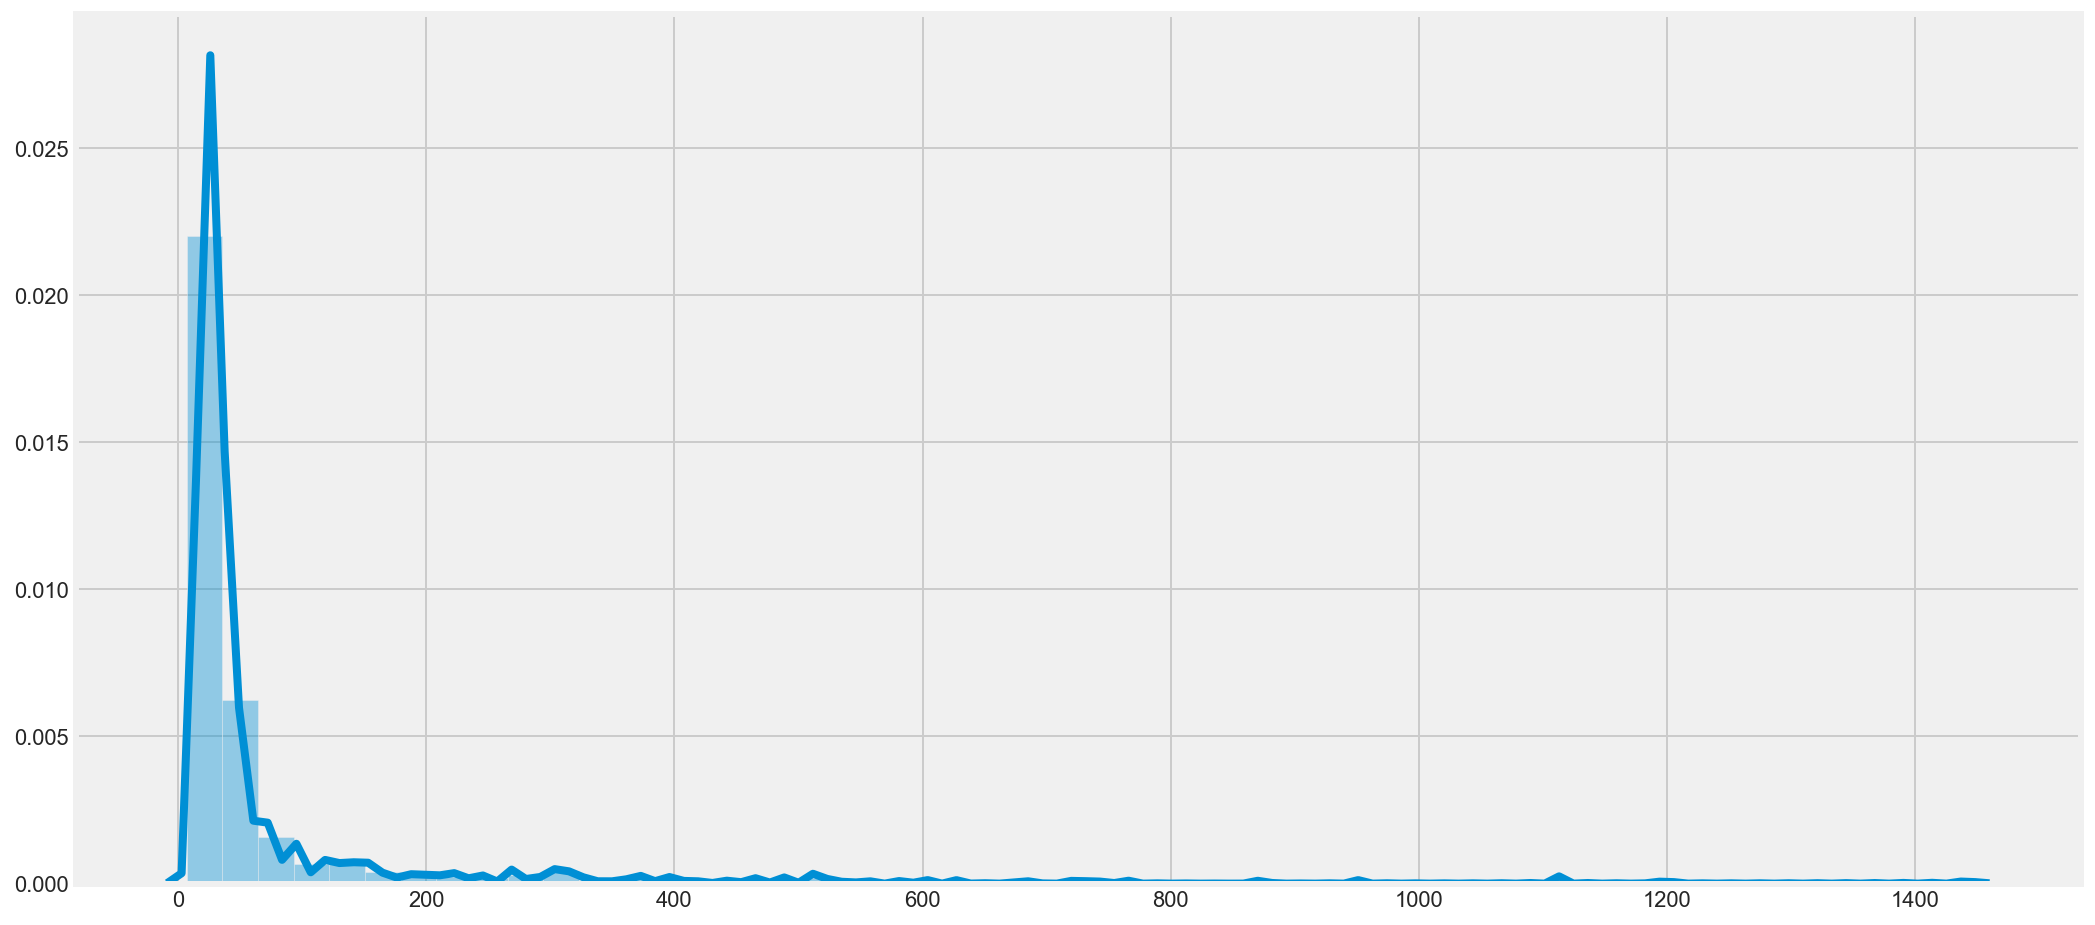

In [25]:
plt.figure(figsize=(16, 8))
sns.distplot(daily_cards, bins=50)

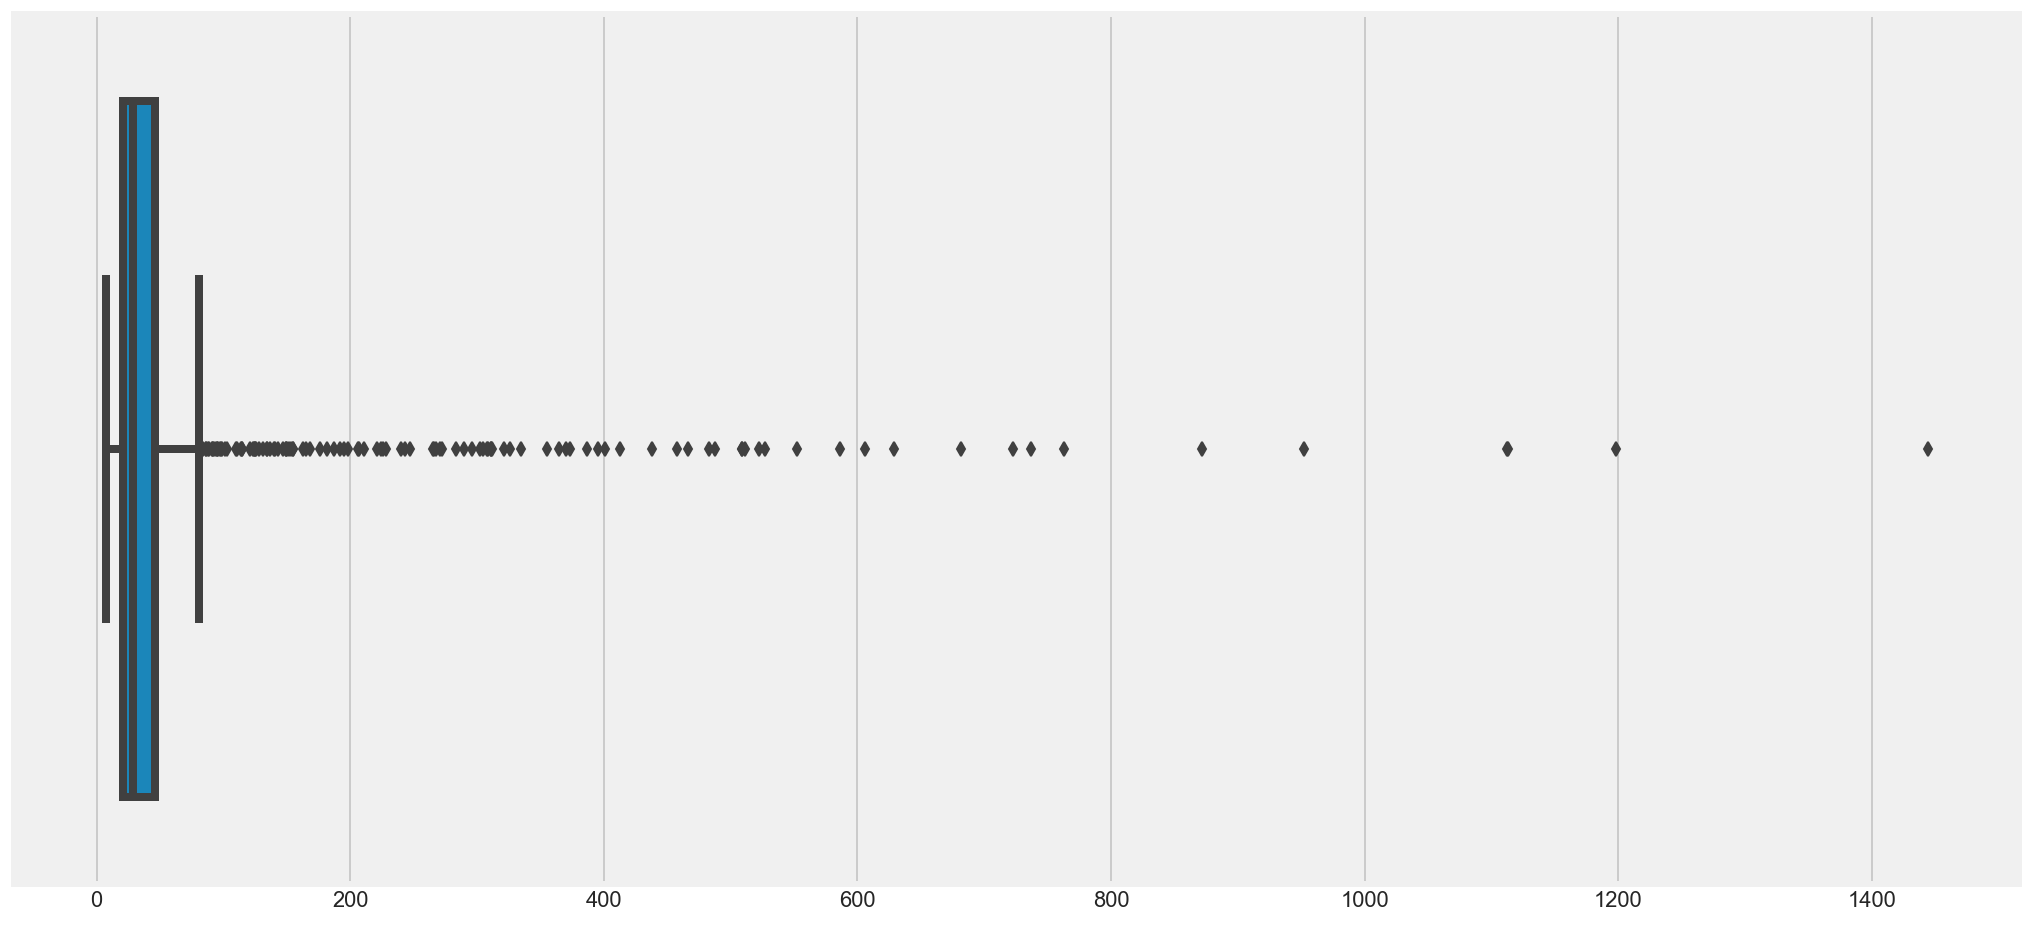

In [26]:
plt.figure(figsize=(16, 8))
sns.boxplot(daily_cards)

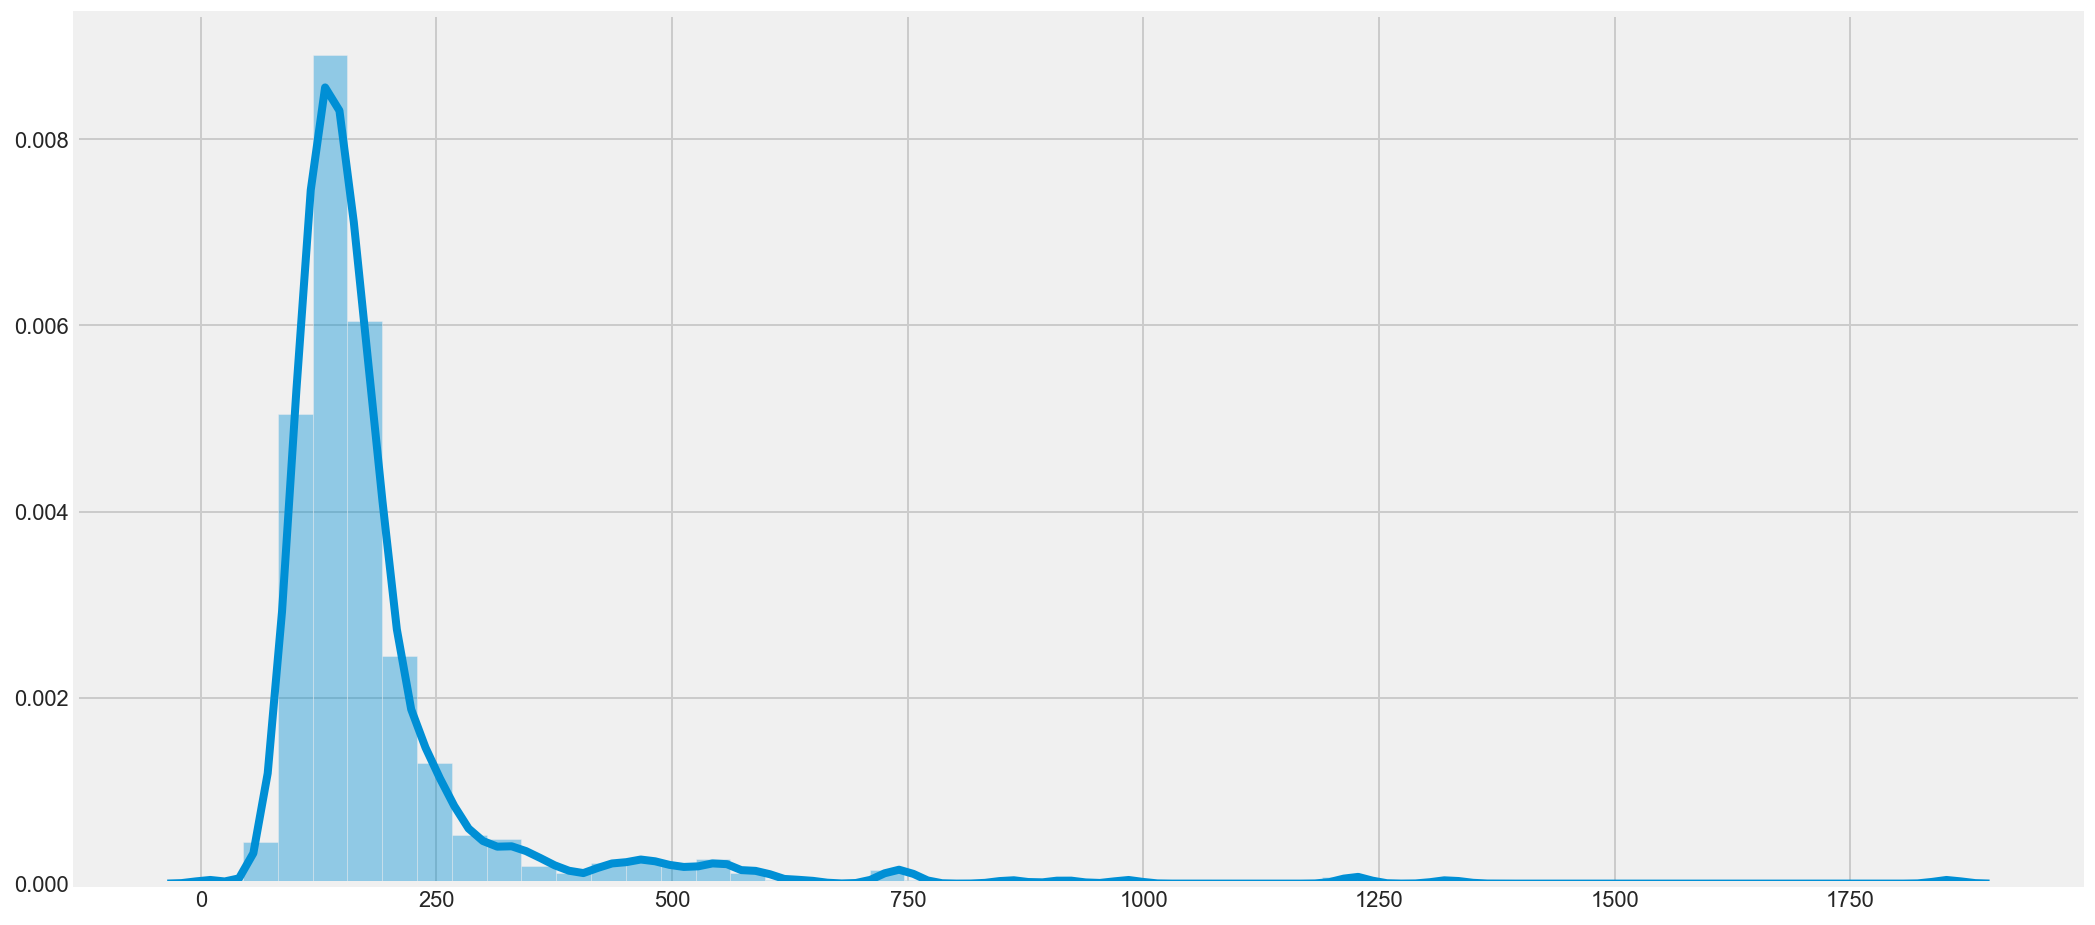

In [27]:
plt.figure(figsize=(16, 8))
sns.distplot(daily_prints, bins=50)

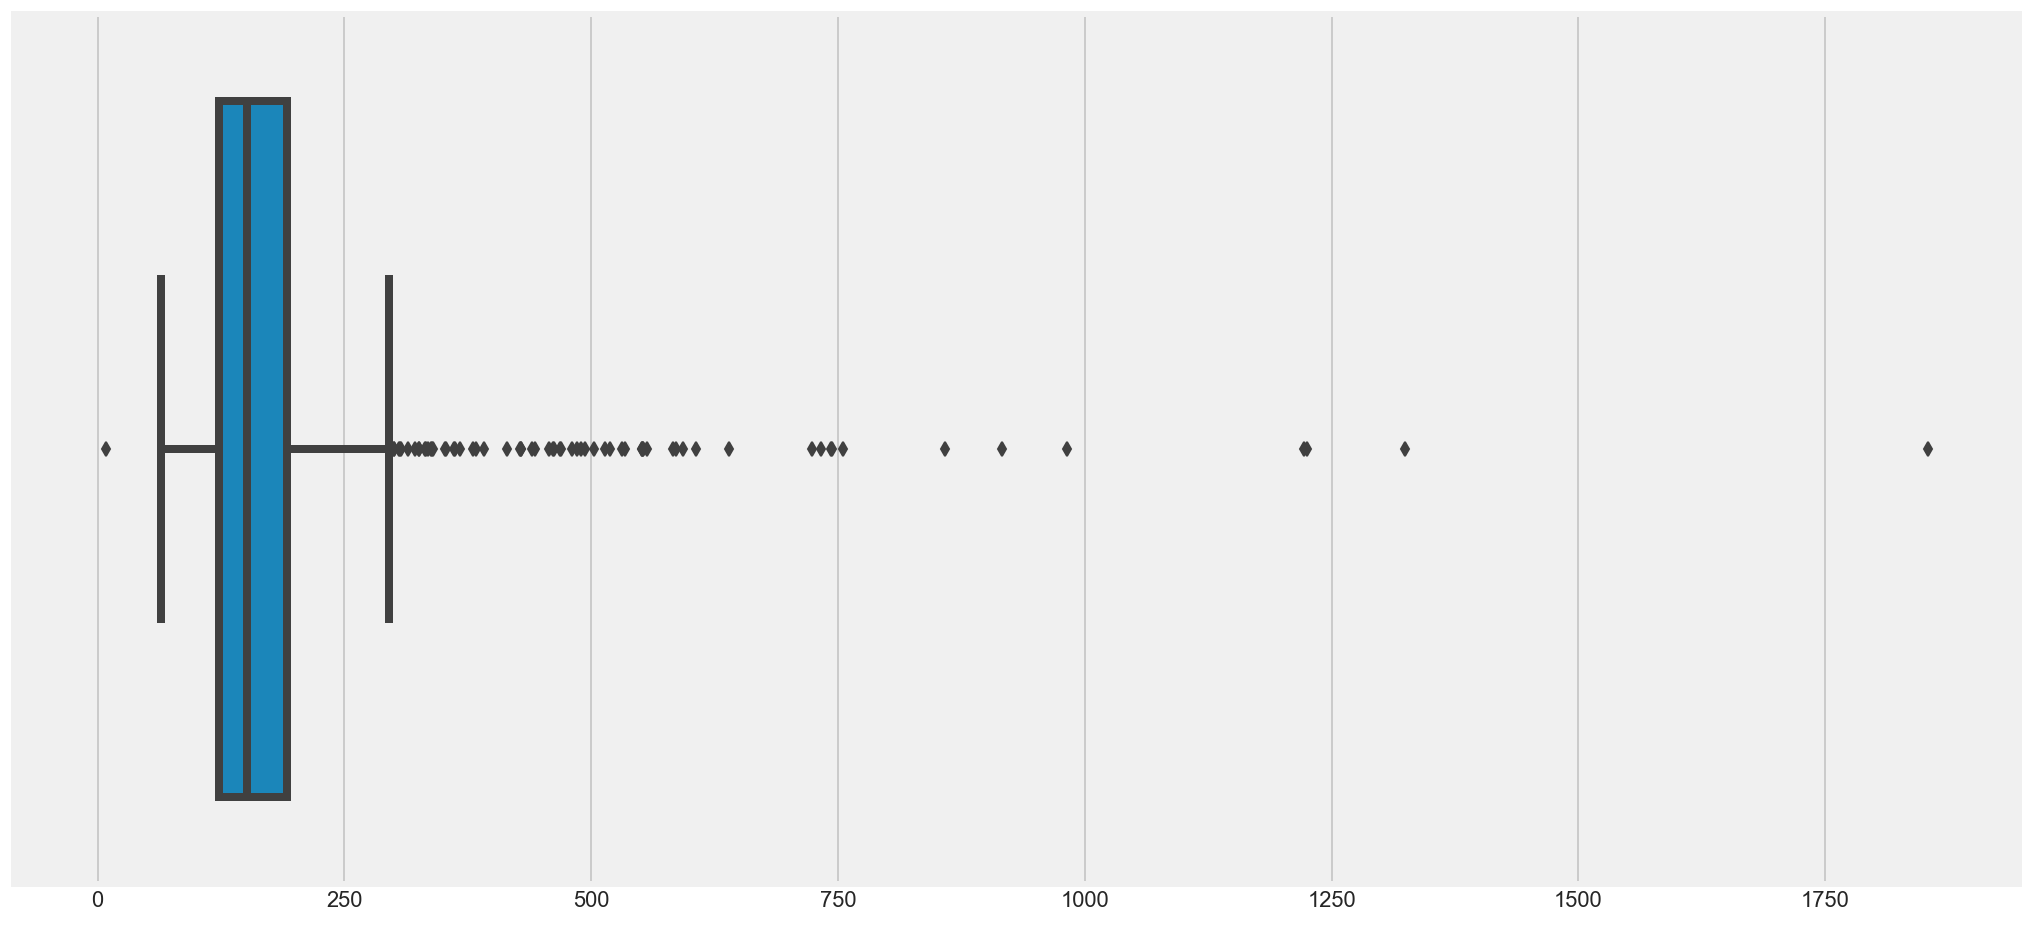

In [28]:
plt.figure(figsize=(16, 8))
sns.boxplot(daily_prints)

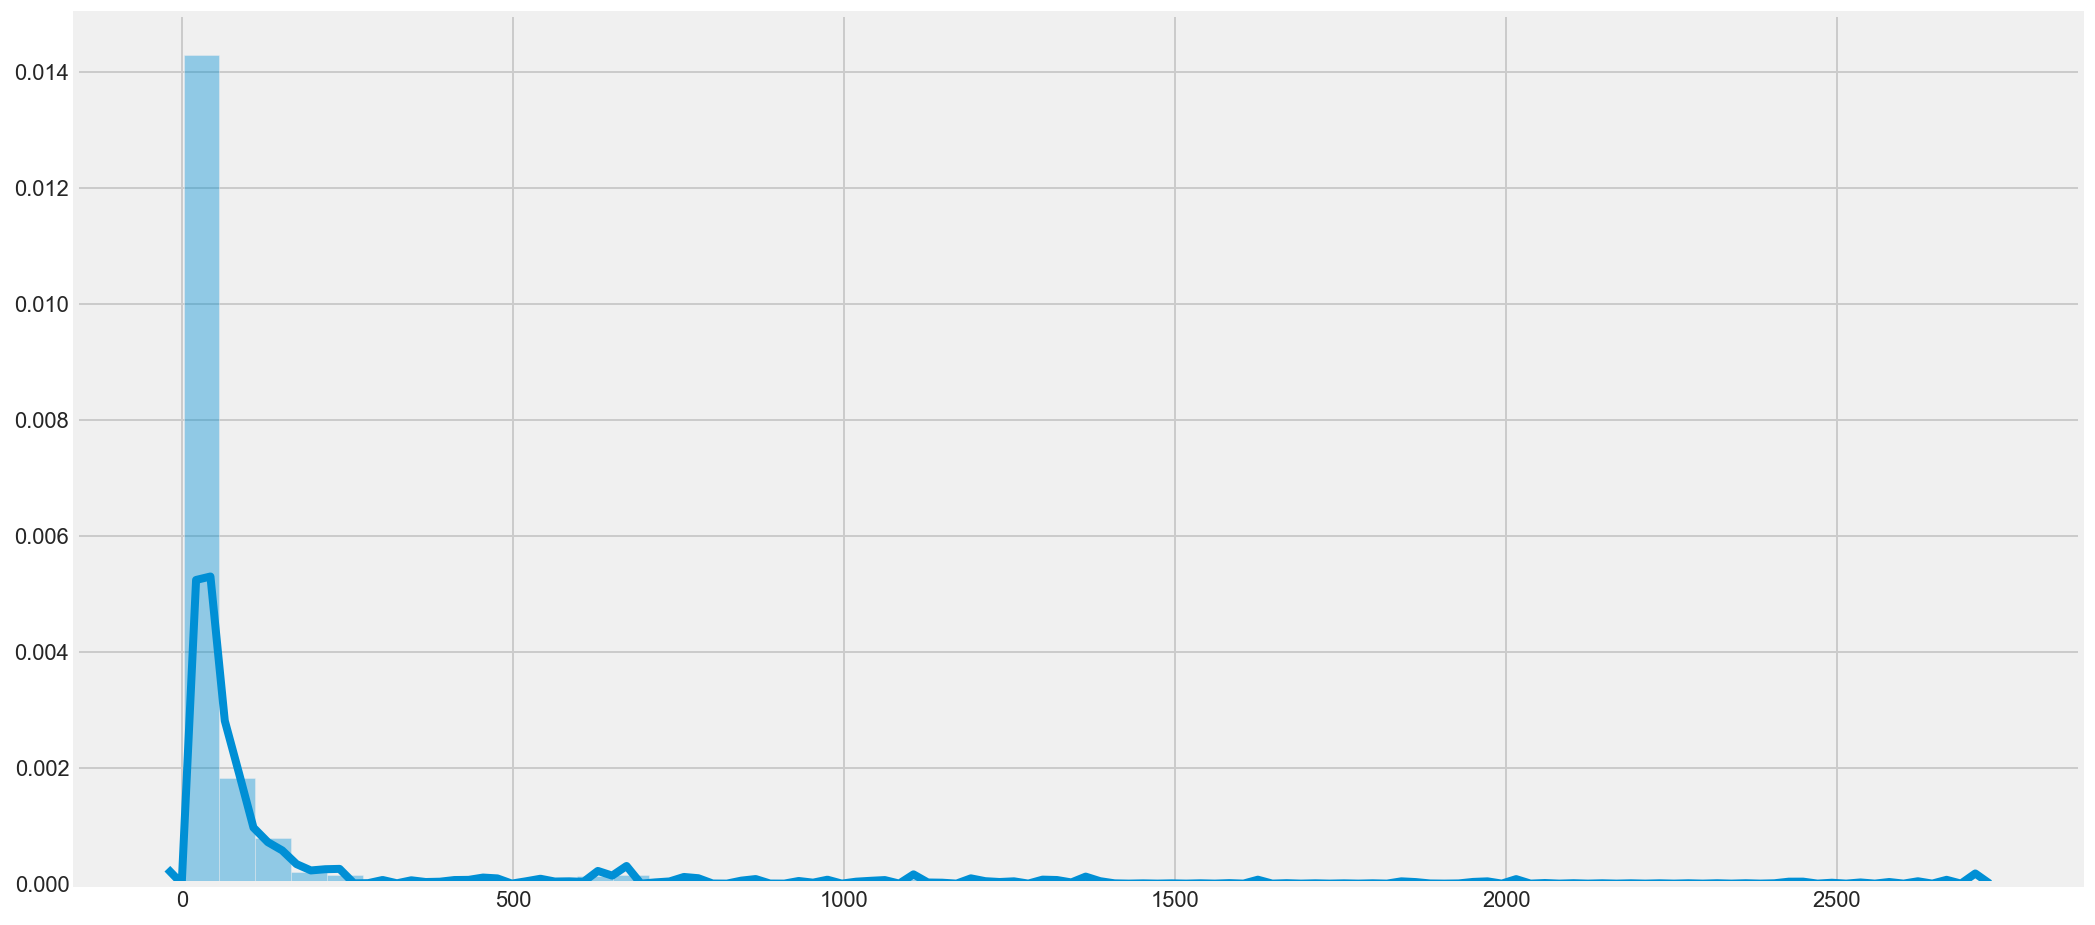

In [29]:
plt.figure(figsize=(16, 8))
sns.distplot(daily_calendars, bins=50)

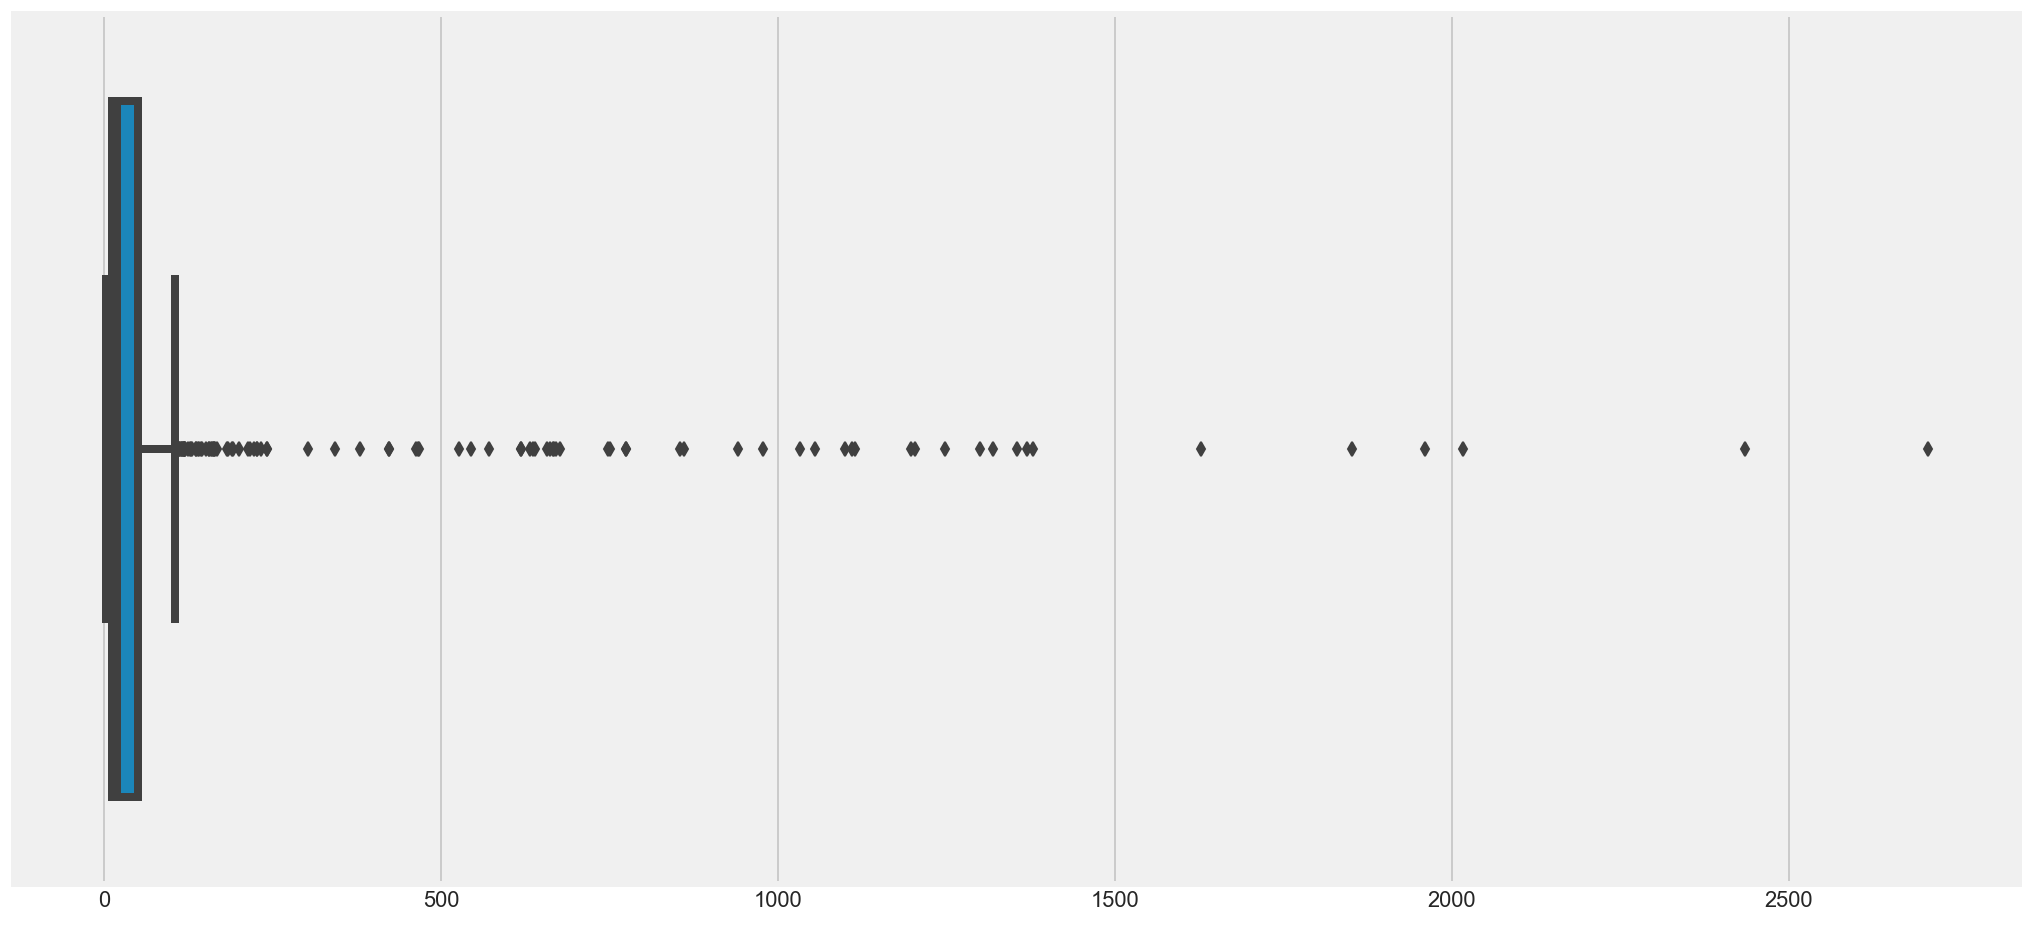

In [30]:
plt.figure(figsize=(16, 8))
sns.boxplot(daily_calendars)

# Season Decomposition

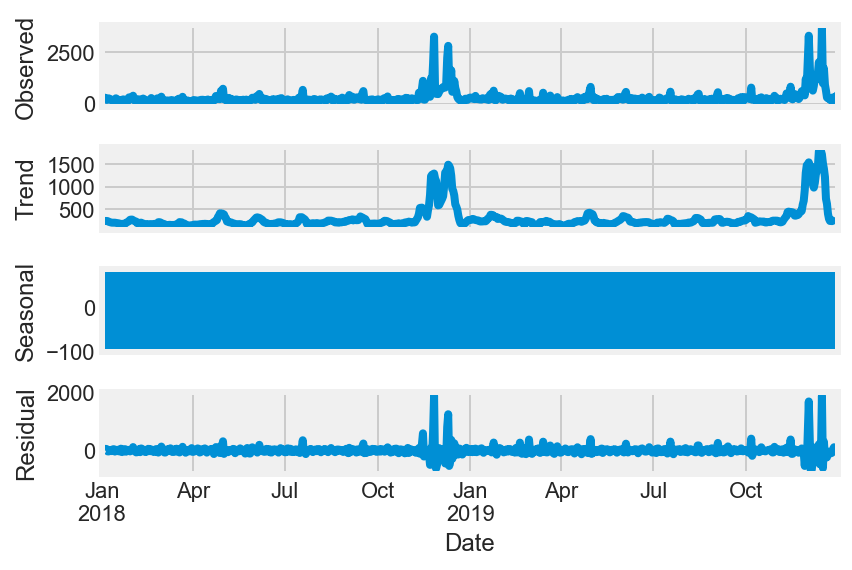

In [31]:
decomposition = sm.tsa.seasonal_decompose(daily_books, model='additive')
fig = decomposition.plot()
plt.show()

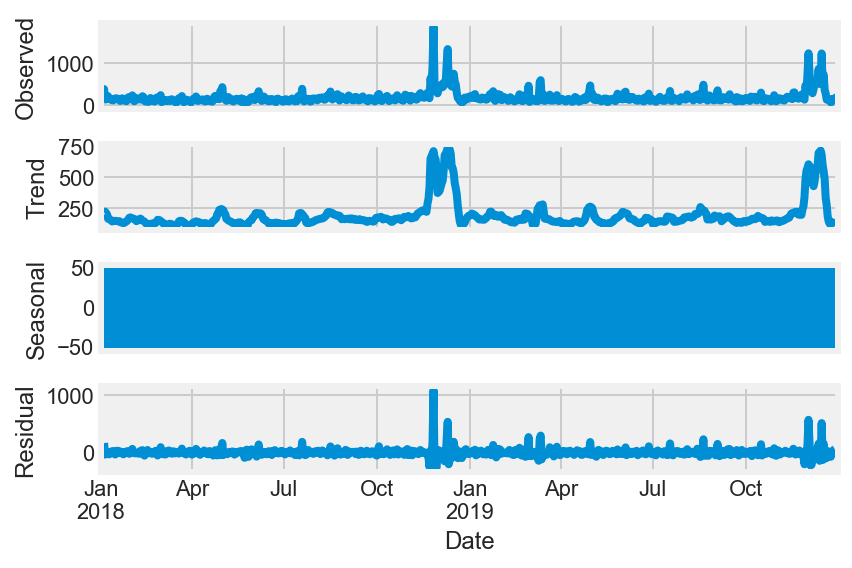

<Figure size 1152x576 with 0 Axes>

In [32]:
decomposition = sm.tsa.seasonal_decompose(daily_prints, model='additive')
fig = decomposition.plot()
plt.figure(figsize=(16, 8))
plt.show()

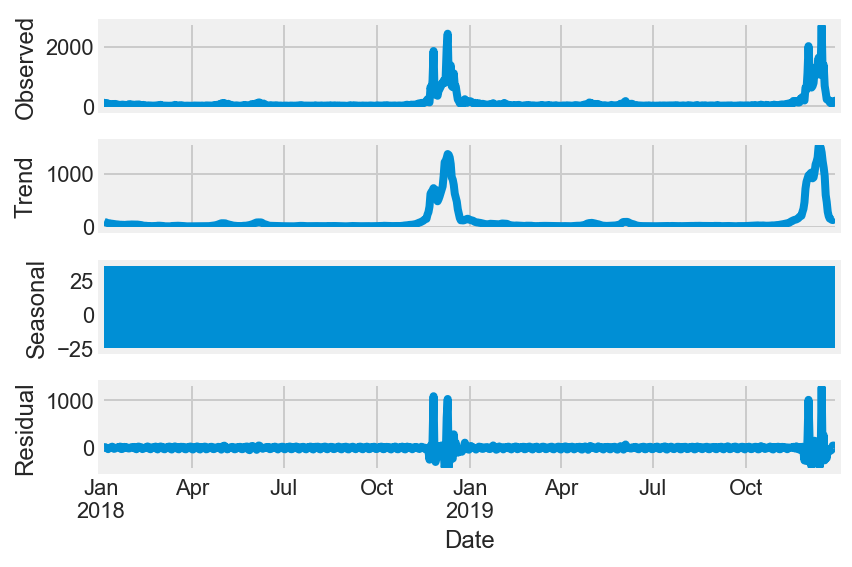

<Figure size 1152x576 with 0 Axes>

In [33]:
decomposition = sm.tsa.seasonal_decompose(daily_calendars, model='additive')
fig = decomposition.plot()
plt.figure(figsize=(16, 8))
plt.show()

# Augmented Dickey Fuller Test

In [34]:
adfuller(daily_books.iloc[:,0].values)[1]

0.0013810173509106551

In [35]:
adfuller(daily_prints.iloc[:,0].values)[1]

0.00046319153600278063

In [36]:
adfuller(daily_cards.iloc[:,0].values)[1]

0.002960600360653692

In [37]:
adfuller(daily_calendars.iloc[:,0].values)[1]

3.6523255080281485e-05